<a href="https://colab.research.google.com/github/OrionXV/Volve-Well-Log-Prediction/blob/main/notebooks/GANaugment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Augmentation

Predictors used:

* Decsion Tree
* Gradient Booster
* Neural Network
* LSTM


In [1]:
!pip install lasio
!pip install md_toc
!pip install tensorflow
!pip install tensorflow-addons
!pip install smogn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 471.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

import lasio

import glob
import os
import md_toc

from sklearn.svm import OneClassSVM

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Bidirectional
from keras.optimizers import Adam

from keras import layers
from keras import models

import tensorflow as tf
from tqdm import tqdm

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Fetching Data

In [4]:
!git clone https://github.com/OrionXV/Volve-Well-Log-Prediction.git

Cloning into 'Volve-Well-Log-Prediction'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 75 (delta 25), reused 9 (delta 3), pack-reused 0
Receiving objects: 100% (75/75), 36.28 MiB | 11.98 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [5]:
# Find paths to the log files (MS windows path style)
paths = sorted(glob.glob(os.path.join(os.getcwd(),"/content/Volve-Well-Log-Prediction/well_logs", "*.LAS")))

# Create a list for loop processing
log_list = [0] * len(paths)

# Parse LAS with LASIO to create pandas df
for i in range(len(paths)):
  df = lasio.read(paths[i])
  log_list[i] = df.df()
  # this transforms the depth from index to regular column
  log_list[i].reset_index(inplace=True)

log_list[0].head()

,DEPTH,ABDCQF01,ABDCQF02,ABDCQF03,ABDCQF04,BS,CALI,DRHO,DT,DTS,...,PEF,RACEHM,RACELM,RD,RHOB,RM,ROP,RPCEHM,RPCELM,RT
0,188.5,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,188.6,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,188.7,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,188.8,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,188.9,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Prepareing Data

In [6]:
# Save logs from list of dfs into separate variables
log1, log2, log3, log4, log5 = log_list
# Lists of depths for clipping
lower = [2600, 3200, 2620, 3100, 3100]
upper = [3720, 4740, 3640, 3400, 4050]

# Lists of selected columns
train_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']
test_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']

log_list_clipped = [0] * len(paths)

for i in range(len(log_list)):

  # Clip depths
  temp_df = log_list[i].loc[
      (log_list[i]['DEPTH'] >= lower[i]) &
      (log_list[i]['DEPTH'] <= upper[i])
  ]

  # Select train-log columns
  if i in [0,2,3]:
    log_list_clipped[i] = temp_df[train_cols]

  # Select test-log columns
  else:
    log_list_clipped[i] = temp_df[test_cols]

# Save logs from list into separate variables
log1, log2, log3, log4, log5 = log_list_clipped
# check for NaN
log1.head()

,DEPTH,NPHI,RHOB,GR,RT,PEF,CALI,DT
24115,2600.0,0.371,2.356,82.748,1.323,7.126,8.648,104.605
24116,2600.1,0.341,2.338,79.399,1.196,6.654,8.578,103.827
24117,2600.2,0.308,2.315,74.248,1.171,6.105,8.578,102.740
24118,2600.3,0.283,2.291,68.542,1.142,5.613,8.547,100.943
24119,2600.4,0.272,2.269,60.314,1.107,5.281,8.523,98.473


In [7]:
# Concatenate dataframes
train = pd.concat([log1, log3, log4])
pred = pd.concat([log2, log5])

# Assign names
names = ['15_9-F-11A', '15_9-F-11B', '15_9-F-1A', '15_9-F-1B', '15_9-F-1C']

names_train = []
names_pred = []

for i in range(len(log_list_clipped)):
  if i in [0,2,3]:
    # Train data, assign names
    names_train.append(np.full(len(log_list_clipped[i]), names[i]))
  else:
    # Test data, assign names
    names_pred.append(np.full(len(log_list_clipped[i]), names[i]))

# Concatenate inside list
names_train = list(itertools.chain.from_iterable(names_train))
names_pred = list(itertools.chain.from_iterable(names_pred))

# Add well name to df
train['WELL'] = names_train
pred['WELL'] = names_pred

# Pop and add depth to end of df
depth_train, depth_pred = train.pop('DEPTH'), pred.pop('DEPTH')
train['DEPTH'], pred['DEPTH'] = depth_train, depth_pred

# Train dataframe with logs 1,3,4 vertically stacked
train.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
24115,0.371,2.356,82.748,1.323,7.126,8.648,104.605,15_9-F-11A,2600.0
24116,0.341,2.338,79.399,1.196,6.654,8.578,103.827,15_9-F-11A,2600.1
24117,0.308,2.315,74.248,1.171,6.105,8.578,102.740,15_9-F-11A,2600.2
24118,0.283,2.291,68.542,1.142,5.613,8.547,100.943,15_9-F-11A,2600.3
24119,0.272,2.269,60.314,1.107,5.281,8.523,98.473,15_9-F-11A,2600.4


In [8]:
colnames = train.columns
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
only_target = 'DT' # only target column names
feature_target = np.append(only_feature, only_target) # feature and target column names

colnames

Index(['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'WELL', 'DEPTH'], dtype='object')

## Data Transformation and Normalization

In [9]:
# Log transform the RT to logarithmic
train['RT'] = np.log10(train['RT'])

# Transformation / Normalizer object Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

# ColumnTransformer (feature_target defines to which it is applied, leave Well and Depth untouched)
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

# Fit and transform
train_trans = ct.fit_transform(train)

# Convert to dataframe
train_trans = pd.DataFrame(train_trans, columns=colnames)
train_trans.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.702168,-0.920748,1.13065,-0.631876,0.031083,0.450019,1.58838,15_9-F-11A,2600.0
1,1.573404,-1.020621,1.092435,-0.736154,-0.373325,-1.070848,1.562349,15_9-F-11A,2600.1
2,1.407108,-1.142493,1.030314,-0.75808,-0.81989,-1.070848,1.525055,15_9-F-11A,2600.2
3,1.260691,-1.263078,0.956135,-0.784153,-1.197992,-1.753641,1.460934,15_9-F-11A,2600.3
4,1.189869,-1.367969,0.837247,-0.816586,-1.441155,-2.286221,1.367432,15_9-F-11A,2600.4


## Outlier Removal

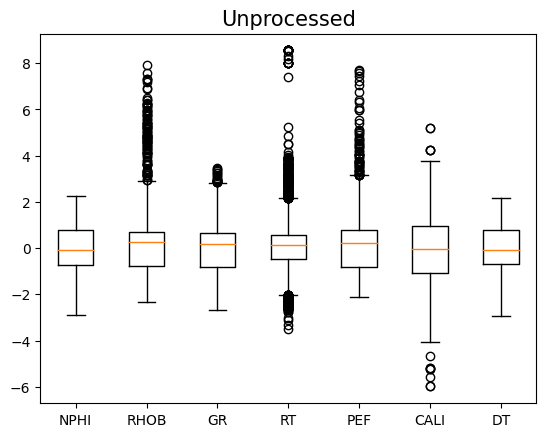

n samples unprocessed: 24403


In [10]:
# Make a copy of train
train_fonly = train_trans.copy()

# Remove WELL, DEPTH
train_fonly = train_fonly.drop(['WELL', 'DEPTH'], axis=1)
train_fonly_names = train_fonly.columns

# Helper function for repeated plotting

def makeboxplot(my_title='enter title',my_data=None):
    _, ax1 = plt.subplots()
    ax1.set_title(my_title, size=15)
    ax1.boxplot(my_data)
    ax1.set_xticklabels(train_fonly_names)
    plt.show()

makeboxplot('Unprocessed',train_trans[train_fonly_names])
print('n samples unprocessed:', len(train_fonly))

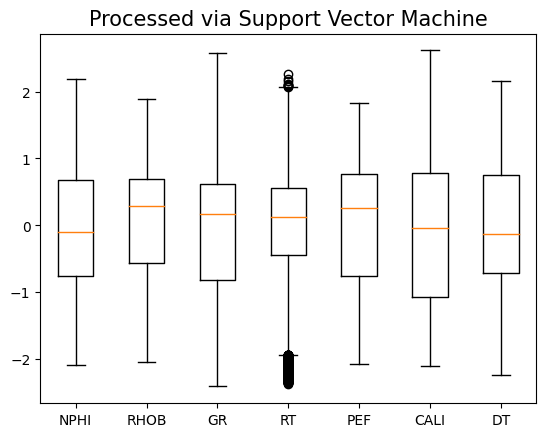

Remaining samples: 21964


In [11]:
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(train_fonly)
mask = yhat != -1
train_svm = train_fonly[mask]

makeboxplot('Processed via Support Vector Machine',train_svm)
print('Remaining samples:', len(train_svm))

In [12]:
feature_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']
target_name = 'DT'


## Train and Validation Prep

In [13]:
# Select columns for features (X) and target (y)
X_train = train_svm[feature_names].values.astype('float32')
y_train = train_svm[target_name].values.reshape(-1, 1).astype('float32')

# Define the validation data
train_trans_copy = train_trans.copy()

train_well_names = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

X_val = []
y_val = []

for i in range(len(train_well_names)):
    # Split the df by log name
    val = train_trans_copy.loc[train_trans_copy['WELL'] == train_well_names[i]].copy()

    # Drop name column
    val.drop(['WELL'], axis=1, inplace=True)

    # Define X_val (feature) and y_val (target) as NumPy arrays
    X_val_ = val[feature_names].values.astype('float32')
    y_val_ = val[target_name].values.reshape(-1, 1).astype('float32')

    X_val.append(X_val_)
    y_val.append(y_val_)

# Save into separate NumPy arrays
X_val1, X_val3, X_val4 = X_val
y_val1, y_val3, y_val4 = y_val

In [14]:
X_train = X_train.astype('float32')

# Cast y_train to float32
y_train = y_train.astype('float32')

# Cast X_val1, X_val3, X_val4 to float32
X_val1 = X_val1.astype('float32')
X_val3 = X_val3.astype('float32')
X_val4 = X_val4.astype('float32')

# Cast y_val1, y_val3, y_val4 to float32
y_val1 = y_val1.astype('float32')
y_val3 = y_val3.astype('float32')
y_val4 = y_val4.astype('float32')

# Data Augmentation

In [15]:
# Select columns for features (X) and target (y)
train_gen = pd.merge(train_svm, train_trans, on = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT'], how='left')

In [16]:
train_gen.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.702168,-0.920748,1.13065,-0.631876,0.031083,0.450019,1.58838,15_9-F-11A,2600.0
1,1.573404,-1.020621,1.092435,-0.736154,-0.373325,-1.070848,1.562349,15_9-F-11A,2600.1
2,1.407108,-1.142493,1.030314,-0.75808,-0.81989,-1.070848,1.525055,15_9-F-11A,2600.2
3,1.260691,-1.263078,0.956135,-0.784153,-1.197992,-1.753641,1.460934,15_9-F-11A,2600.3
4,1.196481,-1.480908,0.579649,-0.636556,-1.495447,-2.108307,1.243336,15_9-F-11A,2600.6


In [17]:
num_features = len(train_gen.drop('WELL', axis = 1).columns)

In [31]:
train_well_names = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

df_gen1 = train_gen[train_gen['WELL'] == '15_9-F-11A'].copy()
df_gen3 = train_gen[train_gen['WELL'] == '15_9-F-1A'].copy()
df_gen4 = train_gen[train_gen['WELL'] == '15_9-F-1B'].copy()

In [32]:
train_gen.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.702168,-0.920748,1.13065,-0.631876,0.031083,0.450019,1.58838,15_9-F-11A,2600.0
1,1.573404,-1.020621,1.092435,-0.736154,-0.373325,-1.070848,1.562349,15_9-F-11A,2600.1
2,1.407108,-1.142493,1.030314,-0.75808,-0.81989,-1.070848,1.525055,15_9-F-11A,2600.2
3,1.260691,-1.263078,0.956135,-0.784153,-1.197992,-1.753641,1.460934,15_9-F-11A,2600.3
4,1.196481,-1.480908,0.579649,-0.636556,-1.495447,-2.108307,1.243336,15_9-F-11A,2600.6


In [33]:
# Fit and transform the 'DEPTH' column for df_gen1
df_gen1['DEPTH'] = scaler.fit_transform(df_gen1[['DEPTH']])

# Fit and transform the 'DEPTH' column for df_gen3
df_gen3['DEPTH'] = scaler.fit_transform(df_gen3[['DEPTH']])

# Fit and transform the 'DEPTH' column for df_gen4
df_gen4['DEPTH'] = scaler.fit_transform(df_gen4[['DEPTH']])

In [34]:
df_gen1

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.702168,-0.920748,1.13065,-0.631876,0.031083,0.450019,1.58838,15_9-F-11A,-1.770311
1,1.573404,-1.020621,1.092435,-0.736154,-0.373325,-1.070848,1.562349,15_9-F-11A,-1.769984
2,1.407108,-1.142493,1.030314,-0.75808,-0.81989,-1.070848,1.525055,15_9-F-11A,-1.769656
3,1.260691,-1.263078,0.956135,-0.784153,-1.197992,-1.753641,1.460934,15_9-F-11A,-1.769329
4,1.196481,-1.480908,0.579649,-0.636556,-1.495447,-2.108307,1.243336,15_9-F-11A,-1.768346
...,...,...,...,...,...,...,...,...,...
10223,0.755866,0.874225,0.927402,-0.243909,0.261839,1.625034,-0.127764,15_9-F-11A,1.769769
10224,0.728607,0.960749,0.809656,-0.248582,0.428544,1.625034,-0.083037,15_9-F-11A,1.770076
10225,0.700885,1.108603,0.763546,-0.26274,0.664207,1.625034,-0.008222,15_9-F-11A,1.770383
10226,0.69154,1.281819,0.777787,-0.286819,0.911909,1.625034,0.108872,15_9-F-11A,1.770690


In [35]:
# Define the GAN model architecture
def build_generator(latent_dim, num_features):
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=latent_dim, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(128, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(256, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(num_features, activation='linear'))  # Output layer
    return model

def build_discriminator(num_features):
    model = models.Sequential()
    model.add(layers.Dense(256, input_shape=(num_features,), activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer
    return model


In [36]:
generator_loss_fn =  tf.keras.losses.BinaryCrossentropy()
discriminator_loss =  tf.keras.losses.BinaryCrossentropy()



In [41]:
def train_gan(generator, discriminator, epochs, batch_size, data_frame, generator_optimizer, discriminator_optimizer):
    data_frame = data_frame

    # Determine the number of batches
    num_samples = len(data_frame)
    num_batches = num_samples // batch_size

    for epoch in range(epochs):
        avg_gen_loss = 0
        avg_disc_loss = 0
        with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:

            for batch in range(num_batches):

                # Get real data for the current batch
                batch_start = batch * batch_size
                batch_end = (batch + 1) * batch_size
                real_data = data_frame.iloc[batch_start:batch_end]
                real_data = real_data.values.astype('float32')

                # Sample random noise for generator input
                noise = np.random.normal(0, 1, size=(len(real_data), latent_dim))

                # Generate synthetic data
                generated_data = generator.predict(noise,  verbose=0)

                # Combine real and generated data
                x_combined = np.concatenate([real_data, generated_data])

                # Labels for real and generated data
                y_real = np.ones((batch_size, 1))
                y_generated = np.zeros((batch_size, 1))
                y_combined = np.concatenate([y_real, y_generated])

                # Train discriminator
                with tf.GradientTape() as disc_tape:
                    # Forward pass: compute logits for real and fake samples
                    real_logits = discriminator(real_data, training=True)
                    fake_logits = discriminator(generated_data, training=True)

                    # Compute discriminator loss
                    real_labels = tf.ones_like(real_logits)
                    fake_labels = tf.zeros_like(fake_logits)
                    discriminator_loss_real = discriminator_loss(real_labels, real_logits)
                    discriminator_loss_fake = discriminator_loss(fake_labels, fake_logits)
                    discriminator_loss_total = (discriminator_loss_real + discriminator_loss_fake)

                # Compute gradients of discriminator loss with respect to discriminator trainable variables
                gradients_of_discriminator = disc_tape.gradient(discriminator_loss_total, discriminator.trainable_variables)

                # Update discriminator weights using optimizer
                discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

                with tf.GradientTape() as gen_tape:
                    # Generate fake samples using the generator
                    fake_samples = generator(noise, training=True)

                    # Compute generator loss
                    generator_loss = generator_loss_fn(real_labels, discriminator(fake_samples, training=True))

                # Compute gradients of generator loss with respect to generator trainable variables
                gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)

                # Update generator weights using optimizer
                generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

                avg_disc_loss += discriminator_loss_total
                avg_gen_loss +=  generator_loss

                pbar.update(1)

            # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Discriminator Loss: {avg_disc_loss/num_batches}, Generator Loss: {avg_gen_loss/num_batches}")


In [38]:
# Generate synthetic data for certain depths
def generate_synthetic_data(generator, num_samples):
    noise = np.random.normal(0, 1, size=(num_samples, latent_dim))
    synthetic_data = generator.predict(noise)
    return synthetic_data


In [39]:
# Train the GAN for log 1
# Define GAN components
latent_dim = 128
generator_1 = build_generator(latent_dim, num_features)
discriminator_1 = build_discriminator(num_features)

generator_optimizer_1 = tf.keras.optimizers.Adam(learning_rate=3e-4)
discriminator_optimizer_1 = tf.keras.optimizers.Adam(learning_rate=3e-4)

epochs = 32
batch_size = 32
num_batches = len(df_gen1) // batch_size
train_gan(generator_1, discriminator_1, epochs, batch_size, df_gen1.drop("WELL", axis = 1), generator_optimizer_1, discriminator_optimizer_1)

Epoch 1/32: 100%|██████████| 319/319 [01:09<00:00,  4.56batch/s]


Epoch 1/32, Discriminator Loss: 1.4314957857131958, Generator Loss: 0.7130774855613708


Epoch 2/32: 100%|██████████| 319/319 [01:06<00:00,  4.83batch/s]


Epoch 2/32, Discriminator Loss: 1.3989288806915283, Generator Loss: 0.6979026198387146


Epoch 3/32: 100%|██████████| 319/319 [01:04<00:00,  4.97batch/s]


Epoch 3/32, Discriminator Loss: 1.3927536010742188, Generator Loss: 0.6956967711448669


Epoch 4/32: 100%|██████████| 319/319 [01:03<00:00,  5.03batch/s]


Epoch 4/32, Discriminator Loss: 1.3905442953109741, Generator Loss: 0.6948662996292114


Epoch 5/32: 100%|██████████| 319/319 [01:04<00:00,  4.95batch/s]


Epoch 5/32, Discriminator Loss: 1.3894225358963013, Generator Loss: 0.6942931413650513


Epoch 6/32: 100%|██████████| 319/319 [01:04<00:00,  4.96batch/s]


Epoch 6/32, Discriminator Loss: 1.3887007236480713, Generator Loss: 0.6940402984619141


Epoch 7/32: 100%|██████████| 319/319 [01:02<00:00,  5.09batch/s]


Epoch 7/32, Discriminator Loss: 1.3881208896636963, Generator Loss: 0.6937981247901917


Epoch 8/32: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s]


Epoch 8/32, Discriminator Loss: 1.3878101110458374, Generator Loss: 0.6936585307121277


Epoch 9/32: 100%|██████████| 319/319 [01:02<00:00,  5.08batch/s]


Epoch 9/32, Discriminator Loss: 1.387585997581482, Generator Loss: 0.6935811042785645


Epoch 10/32: 100%|██████████| 319/319 [01:04<00:00,  4.93batch/s]


Epoch 10/32, Discriminator Loss: 1.3873963356018066, Generator Loss: 0.6934982538223267


Epoch 11/32: 100%|██████████| 319/319 [01:04<00:00,  4.98batch/s]


Epoch 11/32, Discriminator Loss: 1.3872588872909546, Generator Loss: 0.6934350728988647


Epoch 12/32: 100%|██████████| 319/319 [01:03<00:00,  4.98batch/s]


Epoch 12/32, Discriminator Loss: 1.3871670961380005, Generator Loss: 0.693383514881134


Epoch 13/32: 100%|██████████| 319/319 [01:03<00:00,  5.00batch/s]


Epoch 13/32, Discriminator Loss: 1.38717782497406, Generator Loss: 0.6933632493019104


Epoch 14/32: 100%|██████████| 319/319 [01:06<00:00,  4.83batch/s]


Epoch 14/32, Discriminator Loss: 1.3871755599975586, Generator Loss: 0.693343460559845


Epoch 15/32: 100%|██████████| 319/319 [01:04<00:00,  4.96batch/s]


Epoch 15/32, Discriminator Loss: 1.3871557712554932, Generator Loss: 0.6933355331420898


Epoch 16/32: 100%|██████████| 319/319 [01:04<00:00,  4.95batch/s]


Epoch 16/32, Discriminator Loss: 1.3872472047805786, Generator Loss: 0.6933325529098511


Epoch 17/32: 100%|██████████| 319/319 [01:05<00:00,  4.89batch/s]


Epoch 17/32, Discriminator Loss: 1.3870137929916382, Generator Loss: 0.6932803988456726


Epoch 18/32: 100%|██████████| 319/319 [01:04<00:00,  4.97batch/s]


Epoch 18/32, Discriminator Loss: 1.3868496417999268, Generator Loss: 0.6932504773139954


Epoch 19/32: 100%|██████████| 319/319 [01:05<00:00,  4.85batch/s]


Epoch 19/32, Discriminator Loss: 1.3866395950317383, Generator Loss: 0.6932092905044556


Epoch 20/32: 100%|██████████| 319/319 [01:04<00:00,  4.96batch/s]


Epoch 20/32, Discriminator Loss: 1.3866082429885864, Generator Loss: 0.6932063698768616


Epoch 21/32: 100%|██████████| 319/319 [01:04<00:00,  4.96batch/s]


Epoch 21/32, Discriminator Loss: 1.38661527633667, Generator Loss: 0.6931993961334229


Epoch 22/32: 100%|██████████| 319/319 [01:05<00:00,  4.88batch/s]


Epoch 22/32, Discriminator Loss: 1.3866277933120728, Generator Loss: 0.6932013034820557


Epoch 23/32: 100%|██████████| 319/319 [01:04<00:00,  4.98batch/s]


Epoch 23/32, Discriminator Loss: 1.3866488933563232, Generator Loss: 0.6932047605514526


Epoch 24/32: 100%|██████████| 319/319 [01:04<00:00,  4.95batch/s]


Epoch 24/32, Discriminator Loss: 1.3867024183273315, Generator Loss: 0.6932117938995361


Epoch 25/32: 100%|██████████| 319/319 [01:09<00:00,  4.58batch/s]


Epoch 25/32, Discriminator Loss: 1.3866981267929077, Generator Loss: 0.6932036876678467


Epoch 26/32: 100%|██████████| 319/319 [01:06<00:00,  4.82batch/s]


Epoch 26/32, Discriminator Loss: 1.386555790901184, Generator Loss: 0.6931824684143066


Epoch 27/32: 100%|██████████| 319/319 [01:04<00:00,  4.93batch/s]


Epoch 27/32, Discriminator Loss: 1.3865392208099365, Generator Loss: 0.6931848526000977


Epoch 28/32: 100%|██████████| 319/319 [01:08<00:00,  4.65batch/s]


Epoch 28/32, Discriminator Loss: 1.3864920139312744, Generator Loss: 0.6931723952293396


Epoch 29/32: 100%|██████████| 319/319 [01:07<00:00,  4.72batch/s]


Epoch 29/32, Discriminator Loss: 1.3864666223526, Generator Loss: 0.6931687593460083


Epoch 30/32: 100%|██████████| 319/319 [01:06<00:00,  4.77batch/s]


Epoch 30/32, Discriminator Loss: 1.3864749670028687, Generator Loss: 0.69317227602005


Epoch 31/32: 100%|██████████| 319/319 [01:04<00:00,  4.93batch/s]


Epoch 31/32, Discriminator Loss: 1.3864643573760986, Generator Loss: 0.6931658983230591


Epoch 32/32: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s]

Epoch 32/32, Discriminator Loss: 1.386494517326355, Generator Loss: 0.6931746602058411


In [42]:
latent_dim = 128

generator_3 = build_generator(latent_dim, num_features)
discriminator_3 = build_discriminator(num_features)

generator_optimizer_3 = tf.keras.optimizers.Adam(learning_rate=3e-4)
discriminator_optimizer_3 = tf.keras.optimizers.Adam(learning_rate=3e-4)


epochs = 32
batch_size = 32
num_batches = len(df_gen3) // batch_size

train_gan(generator_3, discriminator_3, epochs, batch_size, df_gen3.drop("WELL", axis = 1), generator_optimizer_3, discriminator_optimizer_3)

Epoch 1/32: 100%|██████████| 285/285 [01:02<00:00,  4.57batch/s]


Epoch 1/32, Discriminator Loss: 1.4332354068756104, Generator Loss: 0.7121865153312683


Epoch 2/32: 100%|██████████| 285/285 [01:01<00:00,  4.62batch/s]


Epoch 2/32, Discriminator Loss: 1.403737187385559, Generator Loss: 0.6988952159881592


Epoch 3/32: 100%|██████████| 285/285 [00:58<00:00,  4.90batch/s]


Epoch 3/32, Discriminator Loss: 1.394779086112976, Generator Loss: 0.6962246298789978


Epoch 4/32: 100%|██████████| 285/285 [01:00<00:00,  4.73batch/s]


Epoch 4/32, Discriminator Loss: 1.3917155265808105, Generator Loss: 0.6952529549598694


Epoch 5/32: 100%|██████████| 285/285 [01:00<00:00,  4.73batch/s]


Epoch 5/32, Discriminator Loss: 1.3901866674423218, Generator Loss: 0.6947087049484253


Epoch 6/32: 100%|██████████| 285/285 [00:59<00:00,  4.78batch/s]


Epoch 6/32, Discriminator Loss: 1.3893083333969116, Generator Loss: 0.6943299770355225


Epoch 7/32: 100%|██████████| 285/285 [00:59<00:00,  4.76batch/s]


Epoch 7/32, Discriminator Loss: 1.3886669874191284, Generator Loss: 0.6940868496894836


Epoch 8/32: 100%|██████████| 285/285 [00:58<00:00,  4.90batch/s]


Epoch 8/32, Discriminator Loss: 1.388279676437378, Generator Loss: 0.6939003467559814


Epoch 9/32: 100%|██████████| 285/285 [00:57<00:00,  5.00batch/s]


Epoch 9/32, Discriminator Loss: 1.387984275817871, Generator Loss: 0.6937499642372131


Epoch 10/32: 100%|██████████| 285/285 [00:58<00:00,  4.86batch/s]


Epoch 10/32, Discriminator Loss: 1.3878061771392822, Generator Loss: 0.6936784982681274


Epoch 11/32: 100%|██████████| 285/285 [00:58<00:00,  4.88batch/s]


Epoch 11/32, Discriminator Loss: 1.3875892162322998, Generator Loss: 0.6935850381851196


Epoch 12/32: 100%|██████████| 285/285 [00:57<00:00,  4.96batch/s]


Epoch 12/32, Discriminator Loss: 1.3875665664672852, Generator Loss: 0.6935494542121887


Epoch 13/32: 100%|██████████| 285/285 [00:57<00:00,  5.00batch/s]


Epoch 13/32, Discriminator Loss: 1.3874882459640503, Generator Loss: 0.6934984922409058


Epoch 14/32: 100%|██████████| 285/285 [00:58<00:00,  4.84batch/s]


Epoch 14/32, Discriminator Loss: 1.387434720993042, Generator Loss: 0.6934611797332764


Epoch 15/32: 100%|██████████| 285/285 [00:58<00:00,  4.86batch/s]


Epoch 15/32, Discriminator Loss: 1.387291669845581, Generator Loss: 0.6934072375297546


Epoch 16/32: 100%|██████████| 285/285 [00:57<00:00,  4.96batch/s]


Epoch 16/32, Discriminator Loss: 1.3871183395385742, Generator Loss: 0.6933651566505432


Epoch 17/32: 100%|██████████| 285/285 [01:01<00:00,  4.65batch/s]


Epoch 17/32, Discriminator Loss: 1.387073040008545, Generator Loss: 0.6933722496032715


Epoch 18/32: 100%|██████████| 285/285 [00:59<00:00,  4.76batch/s]


Epoch 18/32, Discriminator Loss: 1.3871378898620605, Generator Loss: 0.6933678984642029


Epoch 19/32: 100%|██████████| 285/285 [00:57<00:00,  4.93batch/s]


Epoch 19/32, Discriminator Loss: 1.387083649635315, Generator Loss: 0.693341076374054


Epoch 20/32: 100%|██████████| 285/285 [01:00<00:00,  4.70batch/s]


Epoch 20/32, Discriminator Loss: 1.386998176574707, Generator Loss: 0.6933053135871887


Epoch 21/32: 100%|██████████| 285/285 [01:00<00:00,  4.74batch/s]


Epoch 21/32, Discriminator Loss: 1.3867977857589722, Generator Loss: 0.6932754516601562


Epoch 22/32: 100%|██████████| 285/285 [00:57<00:00,  4.97batch/s]


Epoch 22/32, Discriminator Loss: 1.3867114782333374, Generator Loss: 0.6932613849639893


Epoch 23/32: 100%|██████████| 285/285 [00:57<00:00,  4.93batch/s]


Epoch 23/32, Discriminator Loss: 1.386654257774353, Generator Loss: 0.6932439804077148


Epoch 24/32: 100%|██████████| 285/285 [00:58<00:00,  4.86batch/s]


Epoch 24/32, Discriminator Loss: 1.386758804321289, Generator Loss: 0.6932579874992371


Epoch 25/32: 100%|██████████| 285/285 [00:56<00:00,  5.02batch/s]


Epoch 25/32, Discriminator Loss: 1.3867608308792114, Generator Loss: 0.6932514905929565


Epoch 26/32: 100%|██████████| 285/285 [00:59<00:00,  4.76batch/s]


Epoch 26/32, Discriminator Loss: 1.3867740631103516, Generator Loss: 0.6932540535926819


Epoch 27/32: 100%|██████████| 285/285 [00:59<00:00,  4.81batch/s]


Epoch 27/32, Discriminator Loss: 1.3867285251617432, Generator Loss: 0.6932359933853149


Epoch 28/32: 100%|██████████| 285/285 [00:59<00:00,  4.82batch/s]


Epoch 28/32, Discriminator Loss: 1.386663556098938, Generator Loss: 0.6932268738746643


Epoch 29/32: 100%|██████████| 285/285 [00:57<00:00,  4.92batch/s]


Epoch 29/32, Discriminator Loss: 1.3866243362426758, Generator Loss: 0.6932125091552734


Epoch 30/32: 100%|██████████| 285/285 [01:02<00:00,  4.52batch/s]


Epoch 30/32, Discriminator Loss: 1.386570930480957, Generator Loss: 0.6932030320167542


Epoch 31/32: 100%|██████████| 285/285 [00:57<00:00,  4.94batch/s]


Epoch 31/32, Discriminator Loss: 1.386561632156372, Generator Loss: 0.6932030916213989


Epoch 32/32: 100%|██████████| 285/285 [00:59<00:00,  4.78batch/s]

Epoch 32/32, Discriminator Loss: 1.3865768909454346, Generator Loss: 0.6932007670402527


In [43]:
latent_dim = 128

generator_4 = build_generator(latent_dim, num_features)
discriminator_4 = build_discriminator(num_features)

generator_optimizer_4 = tf.keras.optimizers.Adam(learning_rate=3e-4)
discriminator_optimizer_4 = tf.keras.optimizers.Adam(learning_rate=3e-4)


epochs = 32
batch_size = 32
num_batches = len(df_gen4) // batch_size

train_gan(generator_4, discriminator_4, epochs, batch_size, df_gen4.drop("WELL", axis = 1), generator_optimizer_4, discriminator_optimizer_4)

Epoch 1/32: 100%|██████████| 81/81 [00:19<00:00,  4.07batch/s]


Epoch 1/32, Discriminator Loss: 1.4808660745620728, Generator Loss: 0.7343877553939819


Epoch 2/32: 100%|██████████| 81/81 [00:16<00:00,  4.81batch/s]


Epoch 2/32, Discriminator Loss: 1.4229750633239746, Generator Loss: 0.7082369327545166


Epoch 3/32: 100%|██████████| 81/81 [00:17<00:00,  4.70batch/s]


Epoch 3/32, Discriminator Loss: 1.4093648195266724, Generator Loss: 0.7038846611976624


Epoch 4/32: 100%|██████████| 81/81 [00:16<00:00,  4.93batch/s]


Epoch 4/32, Discriminator Loss: 1.4033278226852417, Generator Loss: 0.7017067670822144


Epoch 5/32: 100%|██████████| 81/81 [00:16<00:00,  4.78batch/s]


Epoch 5/32, Discriminator Loss: 1.3989331722259521, Generator Loss: 0.7001773715019226


Epoch 6/32: 100%|██████████| 81/81 [00:16<00:00,  4.85batch/s]


Epoch 6/32, Discriminator Loss: 1.3963851928710938, Generator Loss: 0.6991399526596069


Epoch 7/32: 100%|██████████| 81/81 [00:17<00:00,  4.62batch/s]


Epoch 7/32, Discriminator Loss: 1.3953015804290771, Generator Loss: 0.6979418396949768


Epoch 8/32: 100%|██████████| 81/81 [00:16<00:00,  4.78batch/s]


Epoch 8/32, Discriminator Loss: 1.3938908576965332, Generator Loss: 0.6972866654396057


Epoch 9/32: 100%|██████████| 81/81 [00:17<00:00,  4.70batch/s]


Epoch 9/32, Discriminator Loss: 1.3928319215774536, Generator Loss: 0.6970395445823669


Epoch 10/32: 100%|██████████| 81/81 [00:17<00:00,  4.66batch/s]


Epoch 10/32, Discriminator Loss: 1.3921806812286377, Generator Loss: 0.6966407895088196


Epoch 11/32: 100%|██████████| 81/81 [00:17<00:00,  4.66batch/s]


Epoch 11/32, Discriminator Loss: 1.3914207220077515, Generator Loss: 0.6961981058120728


Epoch 12/32: 100%|██████████| 81/81 [00:17<00:00,  4.58batch/s]


Epoch 12/32, Discriminator Loss: 1.3907963037490845, Generator Loss: 0.695971667766571


Epoch 13/32: 100%|██████████| 81/81 [00:16<00:00,  4.81batch/s]


Epoch 13/32, Discriminator Loss: 1.3907262086868286, Generator Loss: 0.6957690119743347


Epoch 14/32: 100%|██████████| 81/81 [00:17<00:00,  4.69batch/s]


Epoch 14/32, Discriminator Loss: 1.3901036977767944, Generator Loss: 0.6954550743103027


Epoch 15/32: 100%|██████████| 81/81 [00:17<00:00,  4.68batch/s]


Epoch 15/32, Discriminator Loss: 1.3899599313735962, Generator Loss: 0.6953370571136475


Epoch 16/32: 100%|██████████| 81/81 [00:17<00:00,  4.72batch/s]


Epoch 16/32, Discriminator Loss: 1.389491319656372, Generator Loss: 0.6950358748435974


Epoch 17/32: 100%|██████████| 81/81 [00:16<00:00,  4.82batch/s]


Epoch 17/32, Discriminator Loss: 1.389371633529663, Generator Loss: 0.6950333714485168


Epoch 18/32: 100%|██████████| 81/81 [00:16<00:00,  4.98batch/s]


Epoch 18/32, Discriminator Loss: 1.3894262313842773, Generator Loss: 0.6948584318161011


Epoch 19/32: 100%|██████████| 81/81 [00:16<00:00,  4.96batch/s]


Epoch 19/32, Discriminator Loss: 1.3894798755645752, Generator Loss: 0.6947799324989319


Epoch 20/32: 100%|██████████| 81/81 [00:16<00:00,  5.06batch/s]


Epoch 20/32, Discriminator Loss: 1.3895983695983887, Generator Loss: 0.6948286294937134


Epoch 21/32: 100%|██████████| 81/81 [00:16<00:00,  4.84batch/s]


Epoch 21/32, Discriminator Loss: 1.3895562887191772, Generator Loss: 0.6946382522583008


Epoch 22/32: 100%|██████████| 81/81 [00:15<00:00,  5.08batch/s]


Epoch 22/32, Discriminator Loss: 1.3899215459823608, Generator Loss: 0.6946015357971191


Epoch 23/32: 100%|██████████| 81/81 [00:16<00:00,  4.97batch/s]


Epoch 23/32, Discriminator Loss: 1.3898125886917114, Generator Loss: 0.694533109664917


Epoch 24/32: 100%|██████████| 81/81 [00:16<00:00,  4.91batch/s]


Epoch 24/32, Discriminator Loss: 1.389488935470581, Generator Loss: 0.6943627595901489


Epoch 25/32: 100%|██████████| 81/81 [00:15<00:00,  5.11batch/s]


Epoch 25/32, Discriminator Loss: 1.3889260292053223, Generator Loss: 0.6943149566650391


Epoch 26/32: 100%|██████████| 81/81 [00:15<00:00,  5.08batch/s]


Epoch 26/32, Discriminator Loss: 1.3888636827468872, Generator Loss: 0.694290280342102


Epoch 27/32: 100%|██████████| 81/81 [00:16<00:00,  4.91batch/s]


Epoch 27/32, Discriminator Loss: 1.3884830474853516, Generator Loss: 0.6941917538642883


Epoch 28/32: 100%|██████████| 81/81 [00:15<00:00,  5.13batch/s]


Epoch 28/32, Discriminator Loss: 1.3885421752929688, Generator Loss: 0.6940840482711792


Epoch 29/32: 100%|██████████| 81/81 [00:16<00:00,  4.91batch/s]


Epoch 29/32, Discriminator Loss: 1.3885927200317383, Generator Loss: 0.6940397620201111


Epoch 30/32: 100%|██████████| 81/81 [00:16<00:00,  4.95batch/s]


Epoch 30/32, Discriminator Loss: 1.3882802724838257, Generator Loss: 0.6939683556556702


Epoch 31/32: 100%|██████████| 81/81 [00:15<00:00,  5.07batch/s]


Epoch 31/32, Discriminator Loss: 1.3884812593460083, Generator Loss: 0.6939918398857117


Epoch 32/32: 100%|██████████| 81/81 [00:16<00:00,  4.95batch/s]

Epoch 32/32, Discriminator Loss: 1.3887357711791992, Generator Loss: 0.6939744353294373


In [44]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_1 = generate_synthetic_data(generator_1, int(len(df_gen1)*0.33))

106/106 [==============================] - 0s 2ms/step


In [45]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_3 = generate_synthetic_data(generator_3, int(len(df_gen3)*0.33))

95/95 [==============================] - 0s 2ms/step


In [46]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_4 = generate_synthetic_data(generator_4, int(len(df_gen4)*0.33))

27/27 [==============================] - 0s 1ms/step


In [47]:
columns = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'DEPTH']

synthetic_df_1 = pd.DataFrame(synthetic_data_1, columns=columns)
synthetic_df_3 = pd.DataFrame(synthetic_data_3, columns=columns)
synthetic_df_4 = pd.DataFrame(synthetic_data_4, columns=columns)


In [48]:
df_gen1.drop('WELL', axis = 1). apply(lambda x: x.astype('float32')).describe()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,DEPTH
count,10228.000000,10228.000000,10228.000000,10228.000000,10228.000000,10228.000000,10228.000000,1.022800e+04
mean,-0.112095,-0.003497,-0.274721,0.056440,0.292885,0.118036,-0.094888,2.386983e-08
std,0.992792,0.944150,0.921068,0.916372,0.998347,0.859239,1.046198,1.000049e+00
min,-2.063082,-2.048020,-2.410065,-2.362914,-1.802307,-2.108307,-2.230961,-1.770311e+00
25%,-0.881575,-0.800520,-0.988074,-0.233863,-0.365790,-0.046527,-0.872950,-8.330449e-01
50%,-0.276245,0.320521,-0.268374,0.237194,0.713391,-0.046527,-0.341816,8.247164e-03
75%,0.719418,0.724360,0.373959,0.662223,1.113527,0.964887,0.827411,8.489204e-01
max,2.159336,1.725365,2.386178,2.267929,1.826932,2.615518,2.152846,1.772531e+00


In [58]:
scaler.fit(train_gen[train_gen['WELL'] == '15_9-F-11A']['DEPTH'].values.reshape(-1, 1))
df_gen1['DEPTH'] = scaler.inverse_transform(df_gen1['DEPTH'].values.reshape(-1, 1))
synthetic_df_1['DEPTH'] = scaler.inverse_transform(synthetic_df_1['DEPTH'].values.reshape(-1, 1))

scaler.fit(train_gen[train_gen['WELL'] == '15_9-F-1A']['DEPTH'].values.reshape(-1, 1))
df_gen3['DEPTH'] = scaler.inverse_transform(df_gen3['DEPTH'].values.reshape(-1, 1))
synthetic_df_3['DEPTH'] = scaler.inverse_transform(synthetic_df_3['DEPTH'].values.reshape(-1, 1))


scaler.fit(train_gen[train_gen['WELL'] == '15_9-F-1B']['DEPTH'].values.reshape(-1, 1))
df_gen4['DEPTH'] = scaler.inverse_transform(df_gen4['DEPTH'].values.reshape(-1, 1))
synthetic_df_4['DEPTH'] = scaler.inverse_transform(synthetic_df_4['DEPTH'].values.reshape(-1, 1))


In [59]:
synthetic_df_1.describe()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,DEPTH
count,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000,3375.000000
mean,0.610611,-1.127943,0.393830,0.908720,2.398326,-2.985594,0.324632,2684.104004
std,0.539427,0.732424,0.723019,1.722267,1.274143,6.043373,0.749542,488.963470
min,-1.227373,-4.334917,-2.663498,-2.712623,-0.034607,-31.385710,-2.871052,352.719543
25%,0.241521,-1.531931,-0.014767,-0.301210,1.557719,-5.957538,-0.182514,2432.111328
50%,0.611540,-1.046568,0.476498,0.579675,2.124619,-1.471893,0.301074,2783.614746
75%,0.972768,-0.626662,0.897121,1.821782,2.877506,1.258989,0.794228,3027.208862
max,2.453626,0.935187,2.540812,9.075308,10.170954,8.418013,3.531503,3769.792236


In [61]:
df_gen3.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
10228,1.177209,-0.664672,0.768284,-0.345274,-0.699239,-1.758064,0.71047,15_9-F-1A,2620.4
10229,1.246224,-1.5904,0.459165,-0.022423,-1.726912,-1.755852,1.197963,15_9-F-1A,2624.7
10230,1.512227,-1.521285,0.592375,0.093696,-1.422967,-1.755852,1.285774,15_9-F-1A,2625.1
10231,1.505787,-1.4486,0.679519,-0.06517,-1.280741,-1.755852,1.301521,15_9-F-1A,2625.2
10232,1.478058,-1.34882,0.825063,-0.225445,-1.155419,-1.755852,1.311003,15_9-F-1A,2625.3


In [62]:
synthetic_df_1['WELL'] = '15_9-F-11A'
synthetic_df_3['WELL'] = '15_9-F-1A'
synthetic_df_4['WELL'] = '15_9-F-1B'

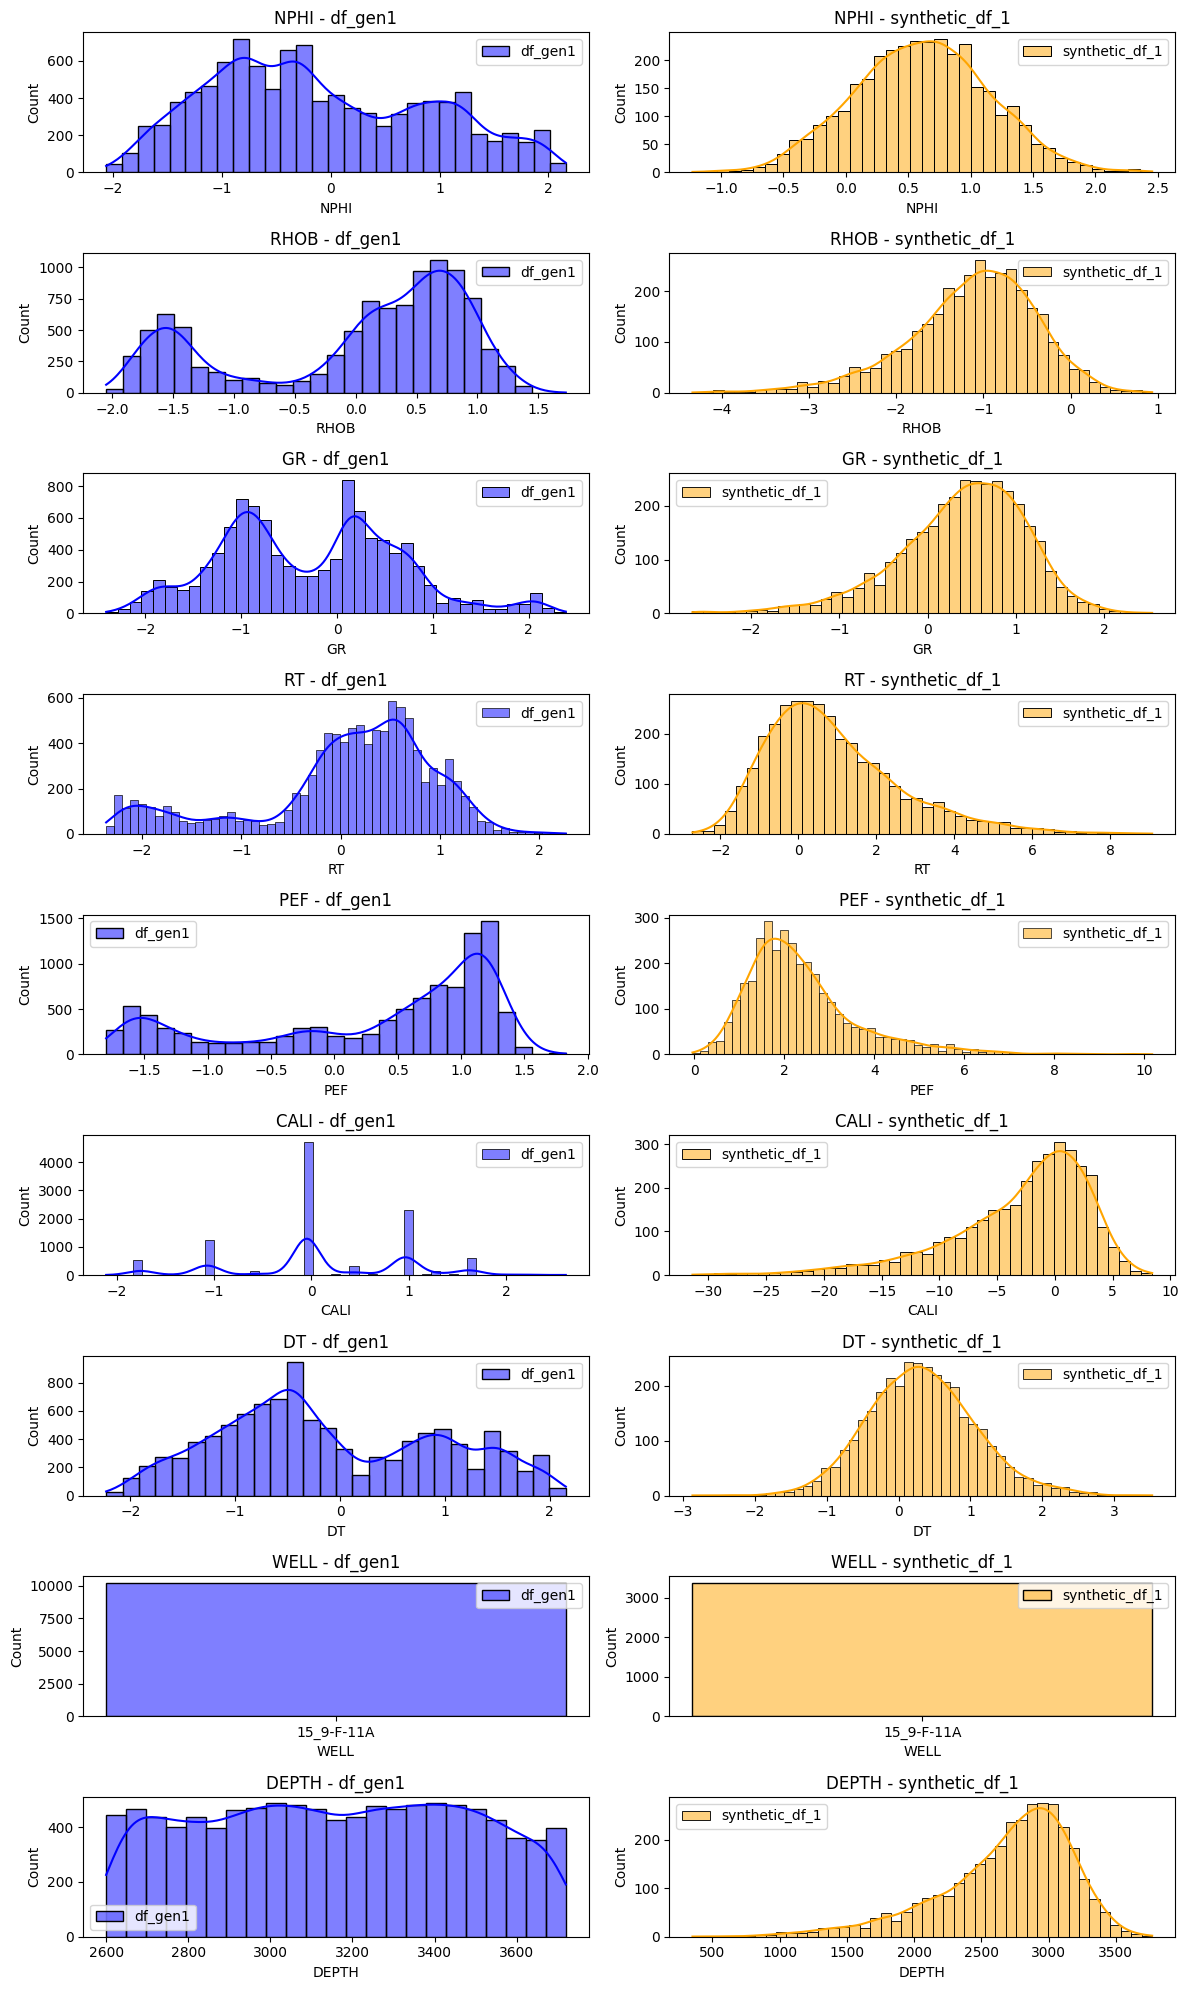

In [63]:
fig, axes = plt.subplots(nrows=len(df_gen1.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen1 and synthetic_df_1
for i, column in enumerate(df_gen1.columns):
    sns.histplot(df_gen1[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen1')
    axes[i, 0].set_title(f'{column} - df_gen1')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_1[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_1')
    axes[i, 1].set_title(f'{column} - synthetic_df_1')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

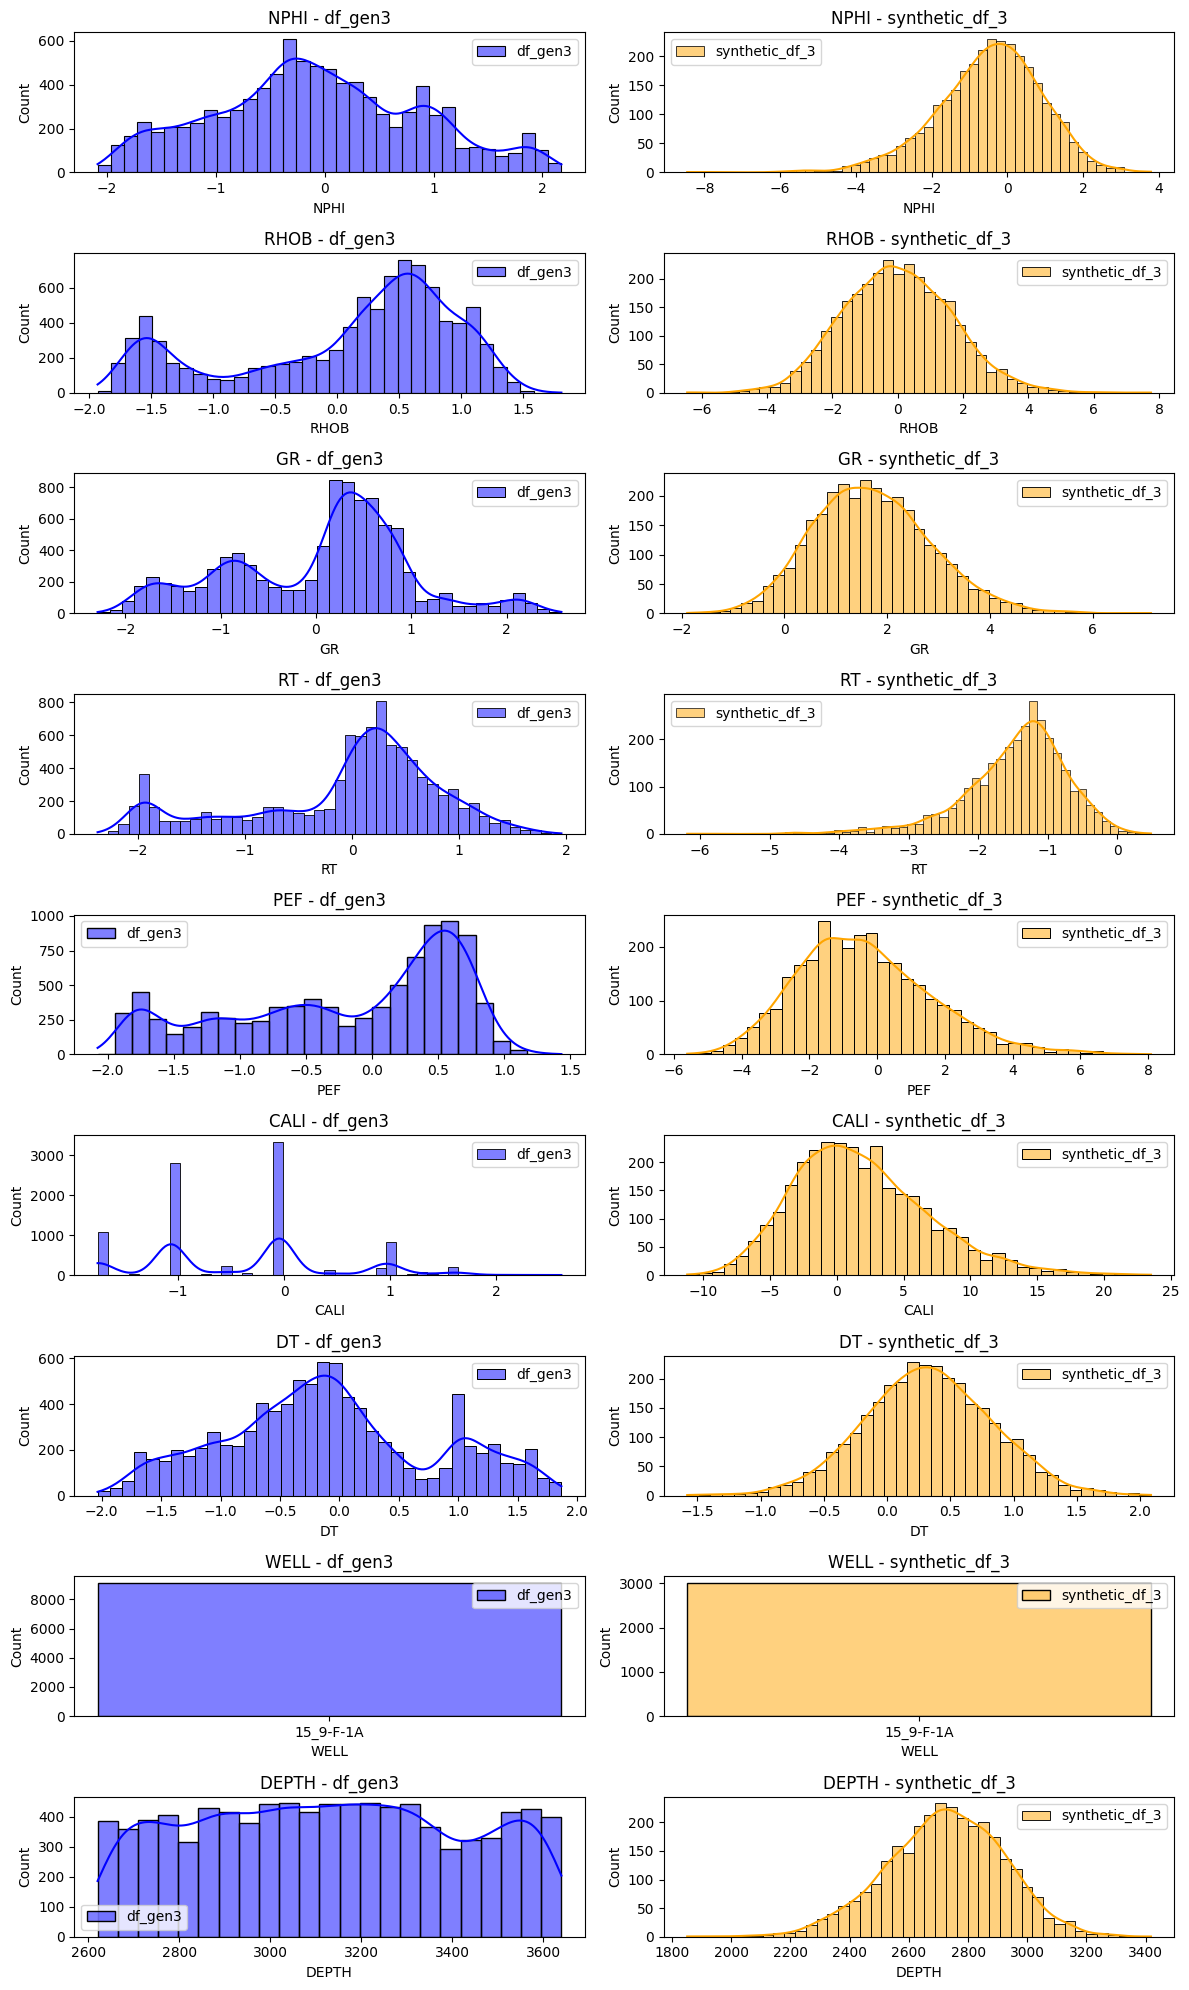

In [64]:
fig, axes = plt.subplots(nrows=len(df_gen3.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen3 and synthetic_df_3
for i, column in enumerate(df_gen3.columns):
    sns.histplot(df_gen3[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen3')
    axes[i, 0].set_title(f'{column} - df_gen3')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_3[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_3')
    axes[i, 1].set_title(f'{column} - synthetic_df_3')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

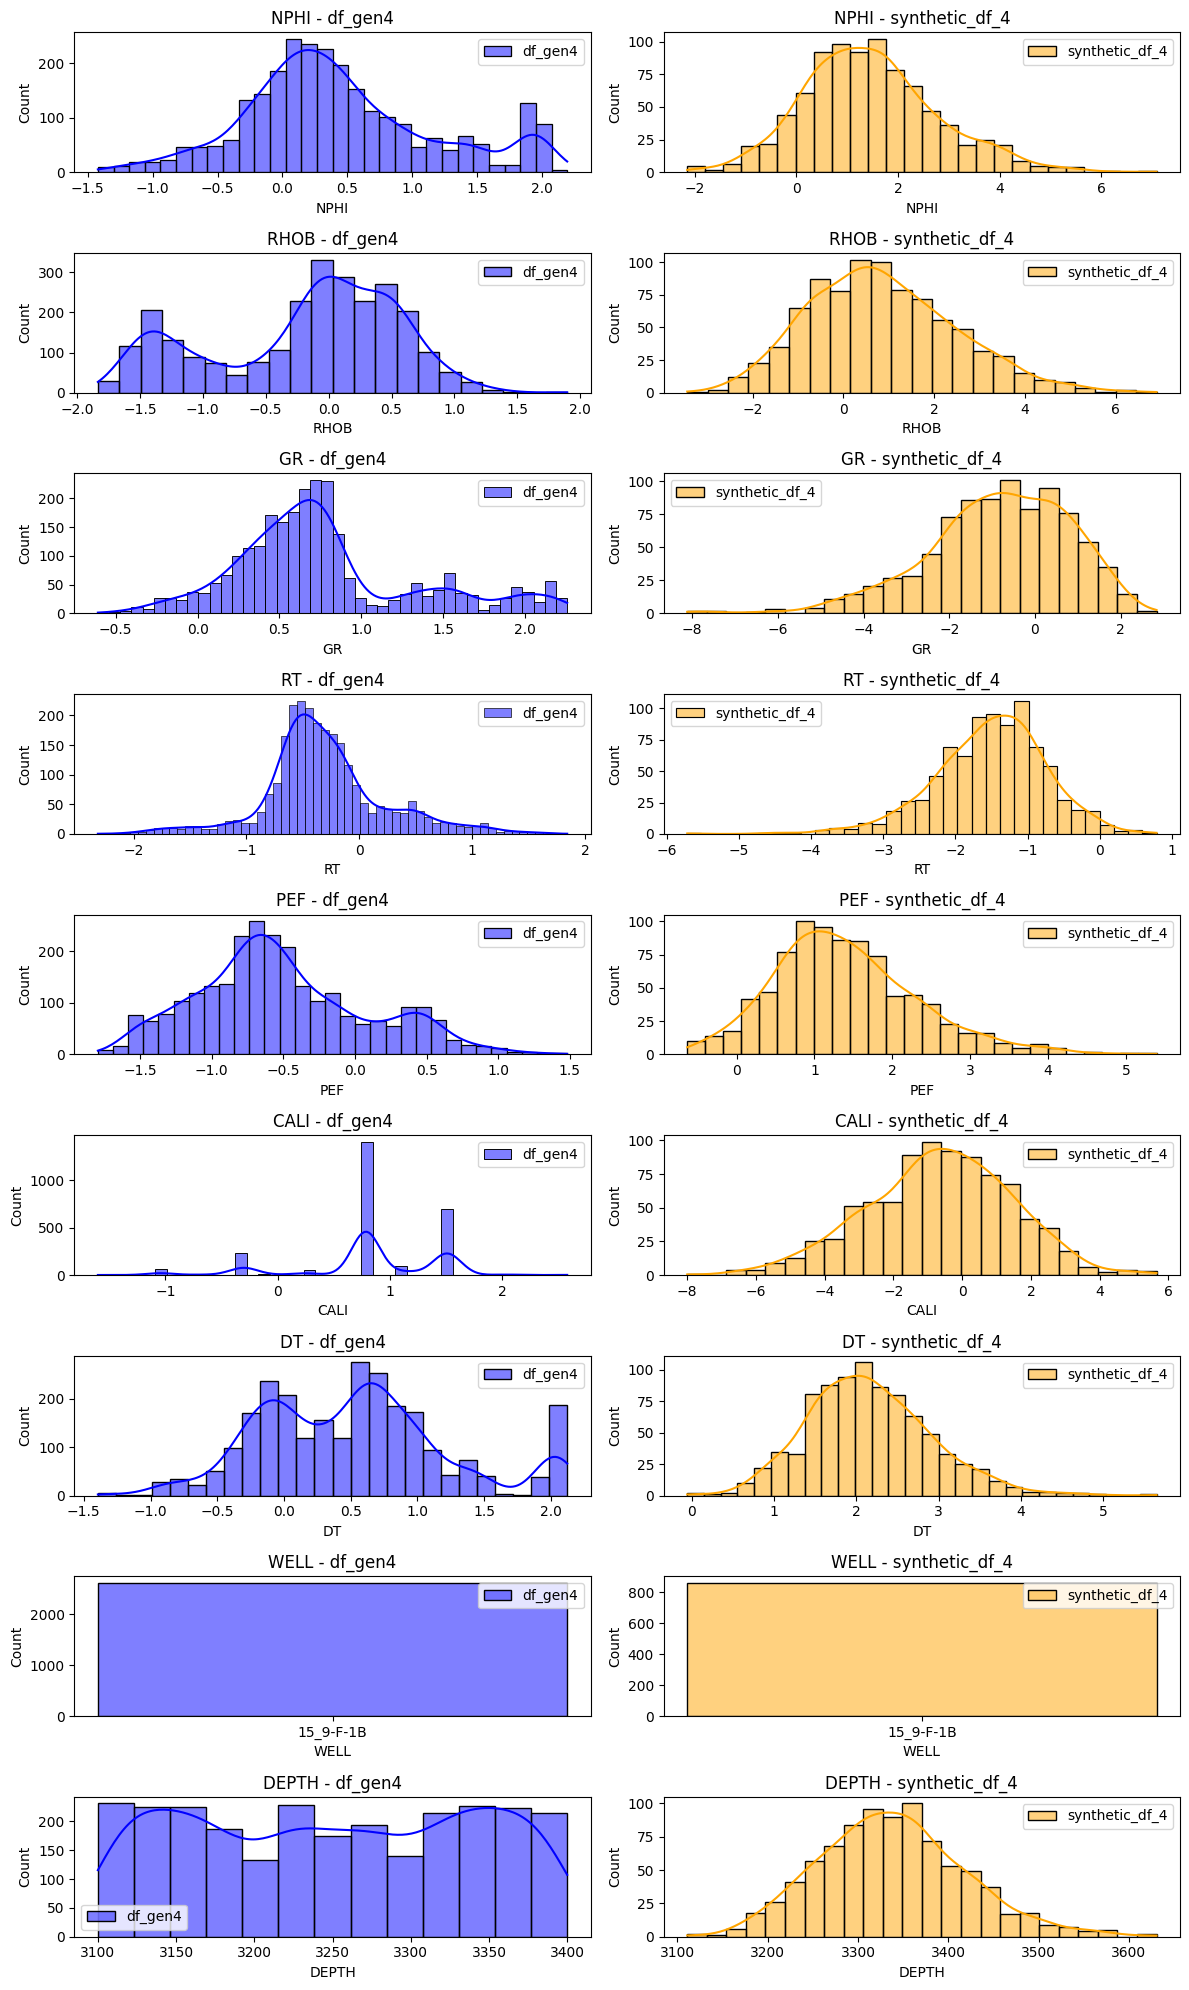

In [65]:
fig, axes = plt.subplots(nrows=len(df_gen4.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen1 and synthetic_df_4
for i, column in enumerate(df_gen4.columns):
    sns.histplot(df_gen4[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen4')
    axes[i, 0].set_title(f'{column} - df_gen4')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_4[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_4')
    axes[i, 1].set_title(f'{column} - synthetic_df_4')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [66]:
df_gen1 = pd.concat([df_gen1, synthetic_df_1])
df_gen1 = df_gen1.sort_values(by='DEPTH')

df_gen3 = pd.concat([df_gen1, synthetic_df_3])
df_gen3  = df_gen3.sort_values(by='DEPTH')

df_gen4 = pd.concat([df_gen1, synthetic_df_4])
df_gen4 = df_gen4.sort_values(by='DEPTH')




,NPHI,RHOB,GR,RT,PEF,CALI,WELL,DEPTH
165,-0.14828,-3.635645,-1.226811,8.719107,9.766696,-31.38571,15_9-F-11A,352.719543
1680,-0.753562,-2.557104,-1.648493,6.700232,8.60454,-28.20998,15_9-F-11A,590.512878
1843,1.043593,-3.036165,-1.404112,8.066074,9.85326,-29.307371,15_9-F-11A,601.250000
2657,1.091139,-4.140275,-2.604203,7.820703,7.794493,-23.52825,15_9-F-11A,762.644653
648,0.767239,-2.695157,-2.534816,7.032682,6.783918,-24.951229,15_9-F-11A,834.984070
...,...,...,...,...,...,...,...,...
10224,0.728607,0.960749,0.809656,-0.248582,0.428544,1.625034,15_9-F-11A,3718.800000
10225,0.700885,1.108603,0.763546,-0.26274,0.664207,1.625034,15_9-F-11A,3718.900000
10226,0.69154,1.281819,0.777787,-0.286819,0.911909,1.625034,15_9-F-11A,3719.000000
10227,0.926387,1.068724,0.978202,-0.420456,0.308667,1.625034,15_9-F-11A,3719.600000


In [79]:
X_train_new = pd.concat([df_gen1, df_gen3, df_gen4])
y_train_new = X_train_new['DT']
X_train_new.drop(['DT', 'WELL', 'DEPTH'], axis = 1, inplace= True)

y_train_new = y_train_new.values.reshape(-1,1).astype('float32')
X_train_new = X_train_new.values.astype('float32')

### Decison Tree Regressor


In [80]:
# Decision Tree Regressor object
model_decision_tree = DecisionTreeRegressor()

# Fit the regressor to the training data
model_decision_tree.fit(X_train_new, y_train_new)

# Validation: Predict on well 1
y_pred1_decision_tree = model_decision_tree.predict(X_val1)
print("R2 Log 1: {}".format(round(model_decision_tree.score(X_val1, y_val1), 4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1_decision_tree))
print("RMSE Log 1: {}".format(round(rmse, 4)))

# Validation: Predict on well 3
y_pred3_decision_tree = model_decision_tree.predict(X_val3)
print("R2 Log 3: {}".format(round(model_decision_tree.score(X_val3, y_val3), 4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3_decision_tree))
print("RMSE Log 3: {}".format(round(rmse, 4)))

# Validation: Predict on well 4
y_pred4_decision_tree = model_decision_tree.predict(X_val4)
print("R2 Log 4: {}".format(round(model_decision_tree.score(X_val4, y_val4), 4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4_decision_tree))
print("RMSE Log 4: {}".format(round(rmse, 4)))


R2 Log 1: 0.9631
RMSE Log 1: 0.2064
R2 Log 3: 0.691
RMSE Log 3: 0.5141
R2 Log 4: 0.5055
RMSE Log 4: 0.5358


### Gradient Booster Regressor

In [81]:
# Gradient Booster object
model_grad_boost = GradientBoostingRegressor()

# Fit the regressor to the training data
model_grad_boost.fit(X_train_new, y_train_new)

# Validation: Predict on well 1
y_pred1_grad_boost = model_grad_boost.predict(X_val1)
print("R2 Log 1: {}".format(round(model_grad_boost.score(X_val1, y_val1),4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1_grad_boost))
print("RMSE Log 1: {}".format(round(rmse,4)))

# Validation: Predict on well 3
y_pred3_grad_boost = model_grad_boost.predict(X_val3)
print("R2 Log 3: {}".format(round(model_grad_boost.score(X_val3, y_val3),4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3_grad_boost))
print("RMSE Log 3: {}".format(round(rmse,4)))

# Validation: Predict on well 4
y_pred4_grad_boost = model_grad_boost.predict(X_val4)
print("R2 Log 4: {}".format(round(model_grad_boost.score(X_val4, y_val4),4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4_grad_boost))
print("RMSE Log 4: {}".format(round(rmse,4)))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 Log 1: 0.9368
RMSE Log 1: 0.2701
R2 Log 3: 0.8362
RMSE Log 3: 0.3743
R2 Log 4: 0.7457
RMSE Log 4: 0.3843


### Neural Network

In [83]:
# Define the neural network model
def neural_network_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer
    ])
    return model

# Initialize and compile the neural network model
model_nn = neural_network_model(X_train_new.shape[1:])
model_nn.compile(optimizer='adam', loss='mean_squared_error')

# Fit the neural network model to the training data
history_nn = model_nn.fit(X_train_new, y_train_new, epochs=16, batch_size=32, validation_data=(X_val1, y_val1))

# Validation: Predict on well 1
y_pred1_nn = model_nn.predict(X_val1)
rmse_nn1 = np.sqrt(mean_squared_error(y_val1, y_pred1_nn))
print("RMSE Neural Network Log 1: {}".format(round(rmse_nn1, 4)))

# Validation: Predict on well 3
y_pred3_nn = model_nn.predict(X_val3)
rmse_nn3 = np.sqrt(mean_squared_error(y_val3, y_pred3_nn))
print("RMSE Neural Network Log 3: {}".format(round(rmse_nn3, 4)))

# Validation: Predict on well 4
y_pred4_nn = model_nn.predict(X_val4)
rmse_nn4 = np.sqrt(mean_squared_error(y_val4, y_pred4_nn))
print("RMSE Neural Network Log 4: {}".format(round(rmse_nn4, 4)))


Epoch 1/16
1397/1397 [==============================] - 6s 3ms/step - loss: 0.1552 - val_loss: 0.0638
Epoch 2/16
1397/1397 [==============================] - 5s 4ms/step - loss: 0.1251 - val_loss: 0.0669
Epoch 3/16
1397/1397 [==============================] - 5s 3ms/step - loss: 0.1202 - val_loss: 0.0637
Epoch 4/16
1397/1397 [==============================] - 5s 3ms/step - loss: 0.1175 - val_loss: 0.0672
Epoch 5/16
1397/1397 [==============================] - 5s 4ms/step - loss: 0.1149 - val_loss: 0.0660
Epoch 6/16
1397/1397 [==============================] - 5s 3ms/step - loss: 0.1129 - val_loss: 0.0724
Epoch 7/16
1397/1397 [==============================] - 5s 4ms/step - loss: 0.1110 - val_loss: 0.0665
Epoch 8/16
1397/1397 [==============================] - 5s 3ms/step - loss: 0.1098 - val_loss: 0.0658
Epoch 9/16
1397/1397 [==============================] - 5s 4ms/step - loss: 0.1091 - val_loss: 0.0647
Epoch 10/16
1397/1397 [==============================] - 5s 3ms/step - loss: 0.107

### LSTM

In [84]:
# Preparing data for LSTM
time_steps = 10

def prep_for_lstm(X_in, y_in, time_steps = 10):
    X_lstm = []
    y_lstm = []
    for i in range(len(X_in) - time_steps):
        X_lstm.append(X_in[i:i+time_steps])
        y_lstm.append(y_in[i+time_steps])

    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)
    return X_lstm, y_lstm

X_train_lstm, y_train_lstm = prep_for_lstm(X_train_new, y_train_new, time_steps = time_steps)
X_val1_lstm, y_val1_lstm = prep_for_lstm(X_val1, y_val1, time_steps = time_steps)
X_val3_lstm, y_val3_lstm = prep_for_lstm(X_val3, y_val3, time_steps = time_steps)
X_val4_lstm, y_val4_lstm = prep_for_lstm(X_val4, y_val4, time_steps = time_steps)


In [85]:
y_train_lstm.shape

(44671, 1)

In [86]:
# Define bidirectional LSTM model with three layers
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model_lstm.add(Bidirectional(LSTM(units=64)))
model_lstm.add(Dense(units=1))  # Output layer
model_lstm.compile(optimizer=Adam(), loss='mean_squared_error')

# Fit the LSTM model to the training data
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=16, batch_size=32, validation_data=(X_val1_lstm, y_val1_lstm))

# Validation: Predict on well 1
y_pred1_lstm = model_lstm.predict(X_val1_lstm)
rmse_lstm1 = np.sqrt(mean_squared_error(y_val1_lstm, y_pred1_lstm))
print("RMSE LSTM Log 1: {}".format(round(rmse_lstm1, 4)))

# Validation: Predict on well 3
y_pred3_lstm = model_lstm.predict(X_val3_lstm)
rmse_lstm3 = np.sqrt(mean_squared_error(y_val3_lstm, y_pred3_lstm))
print("RMSE LSTM Log 3: {}".format(round(rmse_lstm3, 4)))

# Validation: Predict on well 4
y_pred4_lstm = model_lstm.predict(X_val4_lstm)
rmse_lstm4 = np.sqrt(mean_squared_error(y_val4_lstm, y_pred4_lstm))
print("RMSE LSTM Log 4: {}".format(round(rmse_lstm4, 4)))


Epoch 1/16
1396/1396 [==============================] - 28s 13ms/step - loss: 0.4738 - val_loss: 0.1650
Epoch 2/16
1396/1396 [==============================] - 17s 12ms/step - loss: 0.4549 - val_loss: 0.1542
Epoch 3/16
1396/1396 [==============================] - 16s 12ms/step - loss: 0.4474 - val_loss: 0.1069
Epoch 4/16
1396/1396 [==============================] - 17s 12ms/step - loss: 0.4417 - val_loss: 0.1331
Epoch 5/16
1396/1396 [==============================] - 17s 12ms/step - loss: 0.4375 - val_loss: 0.1275
Epoch 6/16
1396/1396 [==============================] - 17s 12ms/step - loss: 0.4328 - val_loss: 0.0788
Epoch 7/16
1396/1396 [==============================] - 16s 12ms/step - loss: 0.4277 - val_loss: 0.1461
Epoch 8/16
1396/1396 [==============================] - 16s 12ms/step - loss: 0.4227 - val_loss: 0.1301
Epoch 9/16
1396/1396 [==============================] - 17s 12ms/step - loss: 0.4174 - val_loss: 0.1037
Epoch 10/16
1396/1396 [==============================] - 16s 12m

### Formatting back the predictions

In [87]:
# Make the transformer fit to the target
y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform  y_val, y_pred
y_val1 = scaler.inverse_transform(y_val1.reshape(-1,1))
y_val3 = scaler.inverse_transform(y_val3.reshape(-1,1))
y_val4 = scaler.inverse_transform(y_val4.reshape(-1,1))


# Define a list to hold all predictions
all_predictions = [y_pred1_grad_boost, y_pred3_grad_boost, y_pred4_grad_boost,
                   y_pred1_nn, y_pred3_nn, y_pred4_nn,
                   y_pred1_lstm, y_pred3_lstm, y_pred4_lstm,
                   y_pred1_decision_tree, y_pred3_decision_tree, y_pred4_decision_tree
                   ]

# Inverse transform all predictions
all_predictions_inverse = [scaler.inverse_transform(pred.reshape(-1, 1)) for pred in all_predictions]

# Split the transformed predictions back into separate variables
(
    y_pred1_grad_boost_inv,  y_pred3_grad_boost_inv, y_pred4_grad_boost_inv,
    y_pred1_nn_inv, y_pred3_nn_inv, y_pred4_nn_inv,
    y_pred1_lstm_inv, y_pred3_lstm_inv, y_pred4_lstm_inv,
    y_pred1_decision_tree_inv, y_pred3_decision_tree_inv, y_pred4_decision_tree_inv
) = all_predictions_inverse

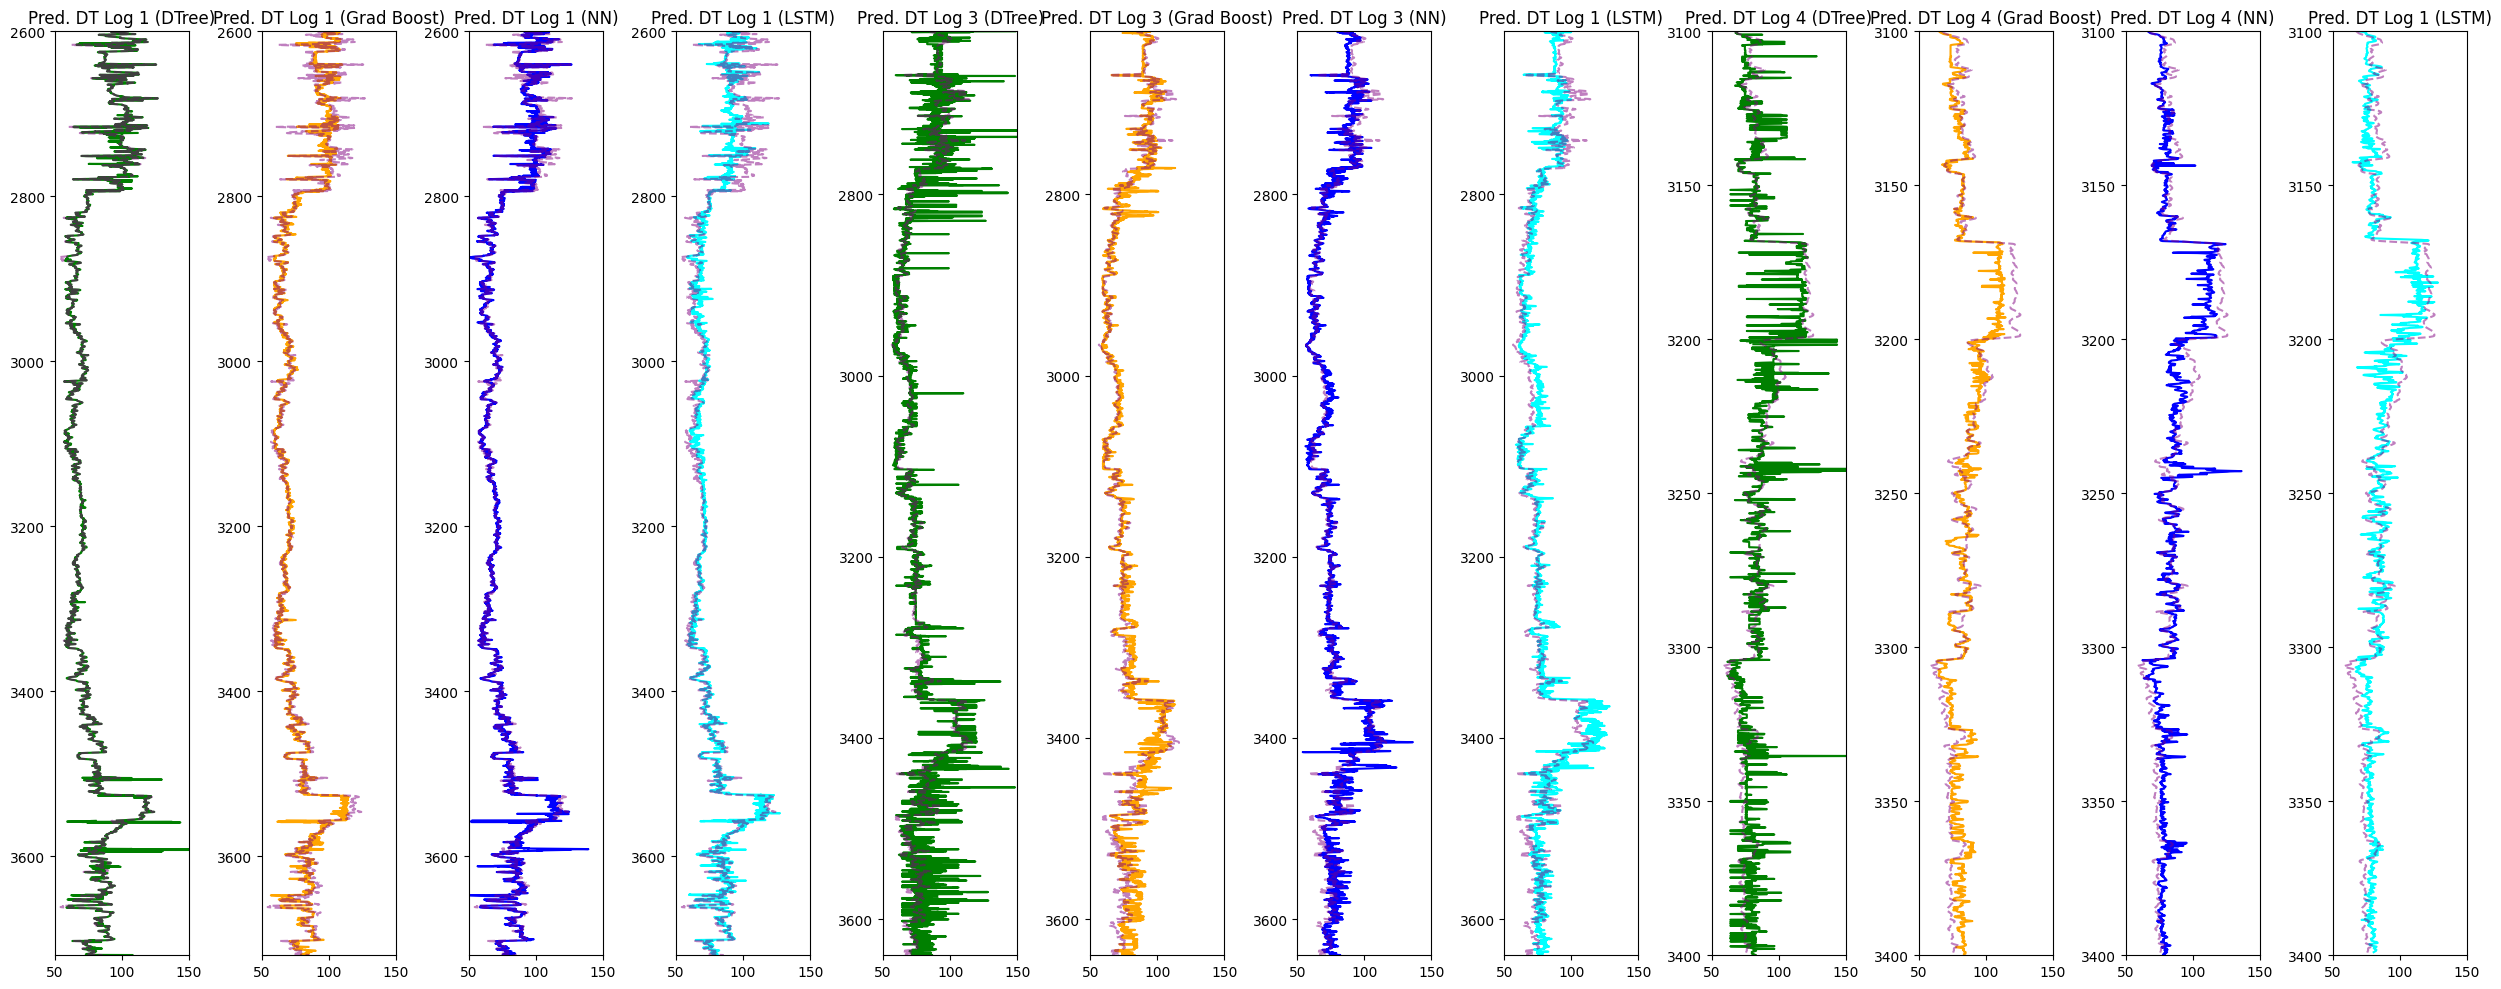

In [88]:
x_plott = [y_pred1_decision_tree_inv, y_pred1_grad_boost_inv, y_pred1_nn_inv,  y_pred1_lstm_inv,
           y_pred3_decision_tree_inv, y_pred3_grad_boost_inv, y_pred3_nn_inv,  y_pred3_lstm_inv,
           y_pred4_decision_tree_inv, y_pred4_grad_boost_inv, y_pred4_nn_inv,  y_pred4_lstm_inv]

x_real_plott = [
    y_val1,
    y_val3,
    y_val4
]

x_real_plott_lstm = [
    y_val1_lstm,
    y_val3_lstm,
    y_val4_lstm
]

y_plott = [log1['DEPTH'],
           log3['DEPTH'],
           log4['DEPTH']]

color_preds = ['green', 'orange', 'blue', 'cyan'] * 3
title_preds = ['Pred. DT Log 1 (DTree)', 'Pred. DT Log 1 (Grad Boost)', 'Pred. DT Log 1 (NN)',  'Pred. DT Log 1 (LSTM)',
               'Pred. DT Log 3 (DTree)', 'Pred. DT Log 3 (Grad Boost)', 'Pred. DT Log 3 (NN)',  'Pred. DT Log 1 (LSTM)',
               'Pred. DT Log 4 (DTree)', 'Pred. DT Log 4 (Grad Boost)', 'Pred. DT Log 4 (NN)',  'Pred. DT Log 1 (LSTM)',]

fig, ax = plt.subplots(nrows=1, ncols=12, figsize=(25, 10))

for i, (x_pred, title) in enumerate(zip(x_plott, title_preds)):
    # Reshape y[i] to match the shape of x_pred
    y_i_reshaped = y_plott[i//4]
    ax[i].plot(x_pred, y_i_reshaped[:len(x_pred)], color=color_preds[i])
    ax[i].plot(x_real_plott[i//4], y_i_reshaped, color='purple', linestyle='dashed', alpha = 0.5) #if i%4 != 0 else x_real_plott_lstm[i//4]
    ax[i].set_xlim(50, 150)
    ax[i].set_ylim(max(y_i_reshaped), min(y_i_reshaped))  # Ensure correct order of y-axis
    ax[i].set_title(title)

plt.tight_layout()
plt.show()


In [89]:
# Define the test data
names_test = ['15_9-F-11B', '15_9-F-1C']

X_test = []
y_test = []
depths = []

for i in range(len(names_test)):
  # split the df with respect to its name
  test = pred.loc[pred['WELL'] == names_test[i]]

  # Drop well name column
  test = test.drop(['WELL'], axis=1)

  # Define X_test (feature)
  X_test_ = test[feature_names].values

  # Define depth
  depth_ = test['DEPTH'].values

  X_test.append(X_test_)
  depths.append(depth_)

# For each well 2 and 5
X_test2, X_test5 = X_test
depth2, depth5 = depths

In [90]:
X_test2

array([[ 0.075,  2.605,  9.348,  8.331,  7.451,  8.547],
       [ 0.077,  2.602,  9.362,  8.289,  7.464,  8.547],
       [ 0.078,  2.599,  9.545,  8.247,  7.405,  8.547],
       ...,
       [ 0.103,  2.592, 32.217,  4.232,  4.729,  8.734],
       [ 0.108,  2.583, 29.841,  4.233,  4.705,  8.75 ],
       [ 0.114,  2.571, 31.423,  4.225,  4.617,  8.76 ]])

In [91]:
# Transform X_test of log 2 and 5
X_test2 = scaler.fit_transform(X_test2)
X_test5 = scaler.fit_transform(X_test5)

X_test2_lstm, _ = prep_for_lstm(X_test2, X_test2, time_steps = time_steps)
X_test5_lstm, _ = prep_for_lstm(X_test5, X_test5, time_steps = time_steps)


# Predictions for log 2 using all models
y_pred2_grad_boost = model_grad_boost.predict(X_test2)
y_pred2_decision_tree = model_decision_tree.predict(X_test2)
y_pred2_nn = model_nn.predict(X_test2)
y_pred2_lstm = model_lstm.predict(X_test2_lstm)
#y_pred2_transformer = model_transformer.predict(X_test2)

# Predictions for log 5 using all models
y_pred5_grad_boost = model_grad_boost.predict(X_test5)
y_pred5_decision_tree = model_decision_tree.predict(X_test5)
y_pred5_nn = model_nn.predict(X_test5)
y_pred5_lstm = model_lstm.predict(X_test5_lstm)
#y_pred5_transformer = model_transformer.predict(X_test5)

y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform y_pred for log 2
y_pred2_grad_boost = scaler.inverse_transform(y_pred2_grad_boost.reshape(-1,1))
y_pred2_decision_tree = scaler.inverse_transform(y_pred2_decision_tree.reshape(-1,1))
y_pred2_nn = scaler.inverse_transform(y_pred2_nn.reshape(-1,1))
y_pred2_lstm = scaler.inverse_transform(y_pred2_lstm.reshape(-1,1))
#y_pred2_transformer = scaler.inverse_transform(y_pred2_transformer.reshape(-1,1))

# Inverse transform y_pred for log 5
y_pred5_grad_boost = scaler.inverse_transform(y_pred5_grad_boost.reshape(-1,1))
y_pred5_decision_tree = scaler.inverse_transform(y_pred5_decision_tree.reshape(-1,1))
y_pred5_nn = scaler.inverse_transform(y_pred5_nn.reshape(-1,1))
y_pred5_lstm = scaler.inverse_transform(y_pred5_lstm.reshape(-1,1))
#y_pred5_transformer = scaler.inverse_transform(y_pred5_transformer.reshape(-1,1))


297/297 [==============================] - 2s 5ms/step


In [92]:
def pad_predicted_values(predicted_values, target_column, window_size=10):
    """
    Pad the predicted values using a moving average to fill in the gaps.

    Parameters:
        predicted_values (np.ndarray): The predicted values to pad.
        target_column (pd.Series): The target column used to calculate moving average.
        window_size (int): The size of the moving average window.

    Returns:
        np.ndarray: The padded predicted values.
    """
    # Calculate the number of values to pad
    pad_length = len(target_column) - len(predicted_values)

    # Pad the predicted values with NaNs to match the length of target_column
    padding = np.full((pad_length, 1), np.nan)

    padded_values = np.concatenate((padding, predicted_values))

    for i in range(len(padded_values)-1, -1, -1):
        if np.isnan(padded_values[i][0]):
            padded_values[i][0] = np.mean(padded_values[i+1:i+1+window_size])



    return padded_values


In [93]:
y_pred2_lstm

array([[65.7828 ],
       [65.95303],
       [66.19705],
       ...,
       [72.20241],
       [71.89793],
       [71.77827]], dtype=float32)

In [94]:
pad_predicted_values(y_pred2_lstm, y_pred2_nn)

array([[66.6385896 ],
       [66.57626632],
       [66.54179229],
       ...,
       [72.20240784],
       [71.89792633],
       [71.77826691]])

In [95]:
# Add predictions for log 2 to the dataframes
log2['DT_grad_boost'] = y_pred2_grad_boost
log2['DT_Tree'] = y_pred2_decision_tree
log2['DT_nn'] = y_pred2_nn
log2['DT_lstm'] = pad_predicted_values(y_pred2_lstm, log2['DT_Tree'])


# Add predictions for log 5 to the dataframes
log5['DT_grad_boost'] = y_pred5_grad_boost
log5['DT_Tree'] = y_pred5_decision_tree
log5['DT_nn'] = y_pred5_nn
log5['DT_lstm'] = pad_predicted_values(y_pred5_lstm, log5['DT_Tree'])
#log5['DT_transformer'] = y_pred5_transformer


<ipython-input-95-b0e2fc4a4f3b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT_grad_boost'] = y_pred5_grad_boost
<ipython-input-95-b0e2fc4a4f3b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT_Tree'] = y_pred5_decision_tree
<ipython-input-95-b0e2fc4a4f3b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

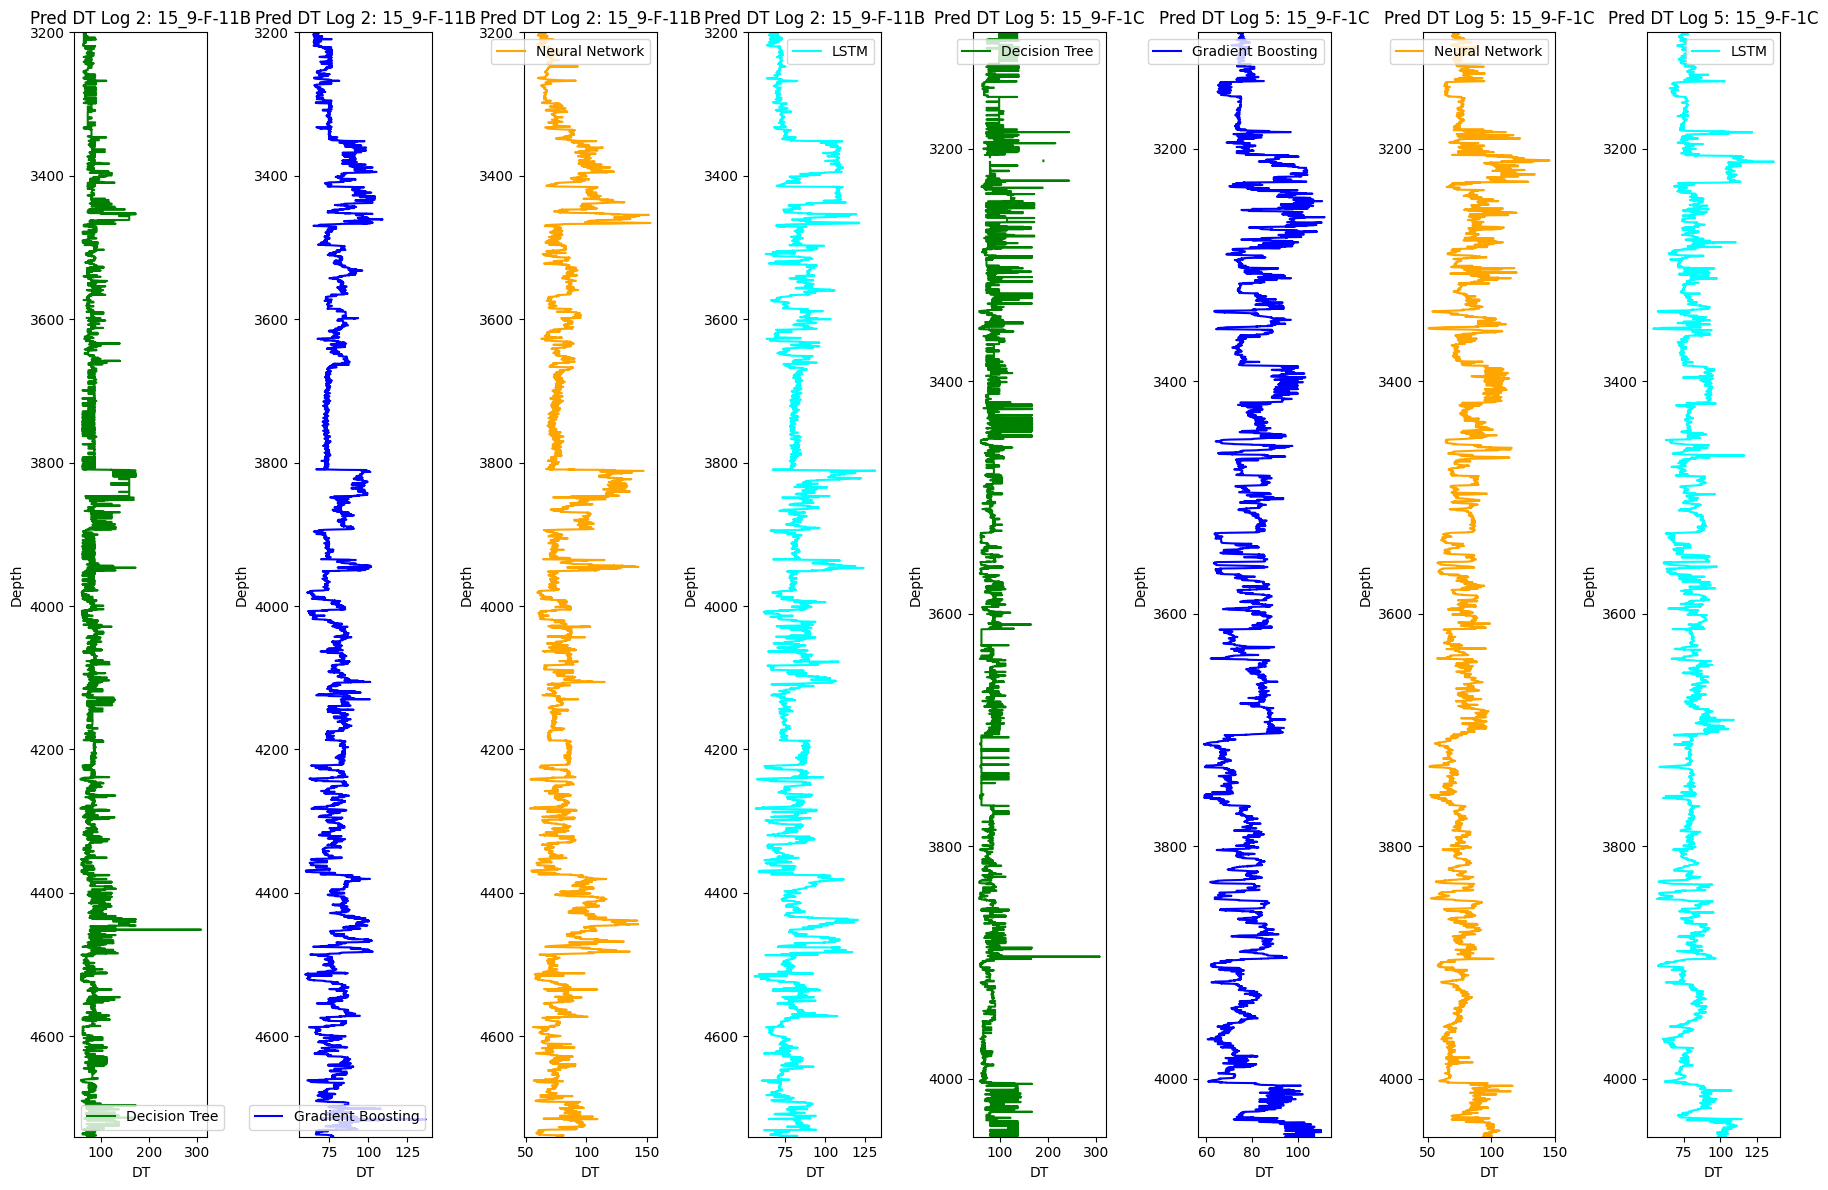

In [96]:
plt.figure(figsize=(18, 12))

# Plot predictions for log 2

plt.subplot(1, 8, 1)
plt.plot(y_pred2_decision_tree, depth2, color='green', label='Decision Tree')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 2)
plt.plot(y_pred2_grad_boost, depth2, color='blue', label='Gradient Boosting')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 3)
plt.plot(y_pred2_nn, depth2, color='orange', label='Neural Network')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 4)
plt.plot(pad_predicted_values(y_pred2_lstm, depth2), depth2, color='cyan', label='LSTM')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

# For log 5

plt.subplot(1, 8, 5)
plt.plot(y_pred5_decision_tree, depth5, color='green', label='Decision Tree')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 6)
plt.plot(y_pred5_grad_boost, depth5, color='blue', label='Gradient Boosting')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 7)
plt.plot(y_pred5_nn, depth5, color='orange', label='Neural Network')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 8)
plt.plot(pad_predicted_values(y_pred5_lstm, depth5), depth5, color='cyan', label='LSTM')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.tight_layout()
plt.show()


In [97]:
def makeplotpred(df, color_list, suptitle_str="Pass a suptitle"):
    # Column selection from df
    col_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT_Tree', 'DT_grad_boost', 'DT_nn', 'DT_lstm']
    # Plotting titles
    title = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'Predicted DT Decsion Tree', 'Predicted DT GB', 'Predicted DT NN', 'Predicted DT LSTM']

    # Create the subplots; ncols equals the number of logs
    fig, ax = plt.subplots(nrows=1, ncols=len(col_names), figsize=(20,15))
    fig.suptitle(suptitle_str, size=20, y=1.05)

    # Looping each log to display in the subplots
    for i in range(len(col_names)):
        if i == 3:
            # for resistivity, semilog plot
            ax[i].semilogx(df[col_names[i]], df['DEPTH'], color=color_list[i])

        else:
            # for non-resistivity, normal plot
            ax[i].plot(df[col_names[i]], df['DEPTH'], color=color_list[i])

        ax[i].set_ylim(max(df['DEPTH']), min(df['DEPTH']))
        ax[i].set_title(title[i], pad=15)
        ax[i].grid(True)
        ax[i].legend()

    ax[2].set_xlim(0, 200)
    plt.tight_layout()
    plt.show()

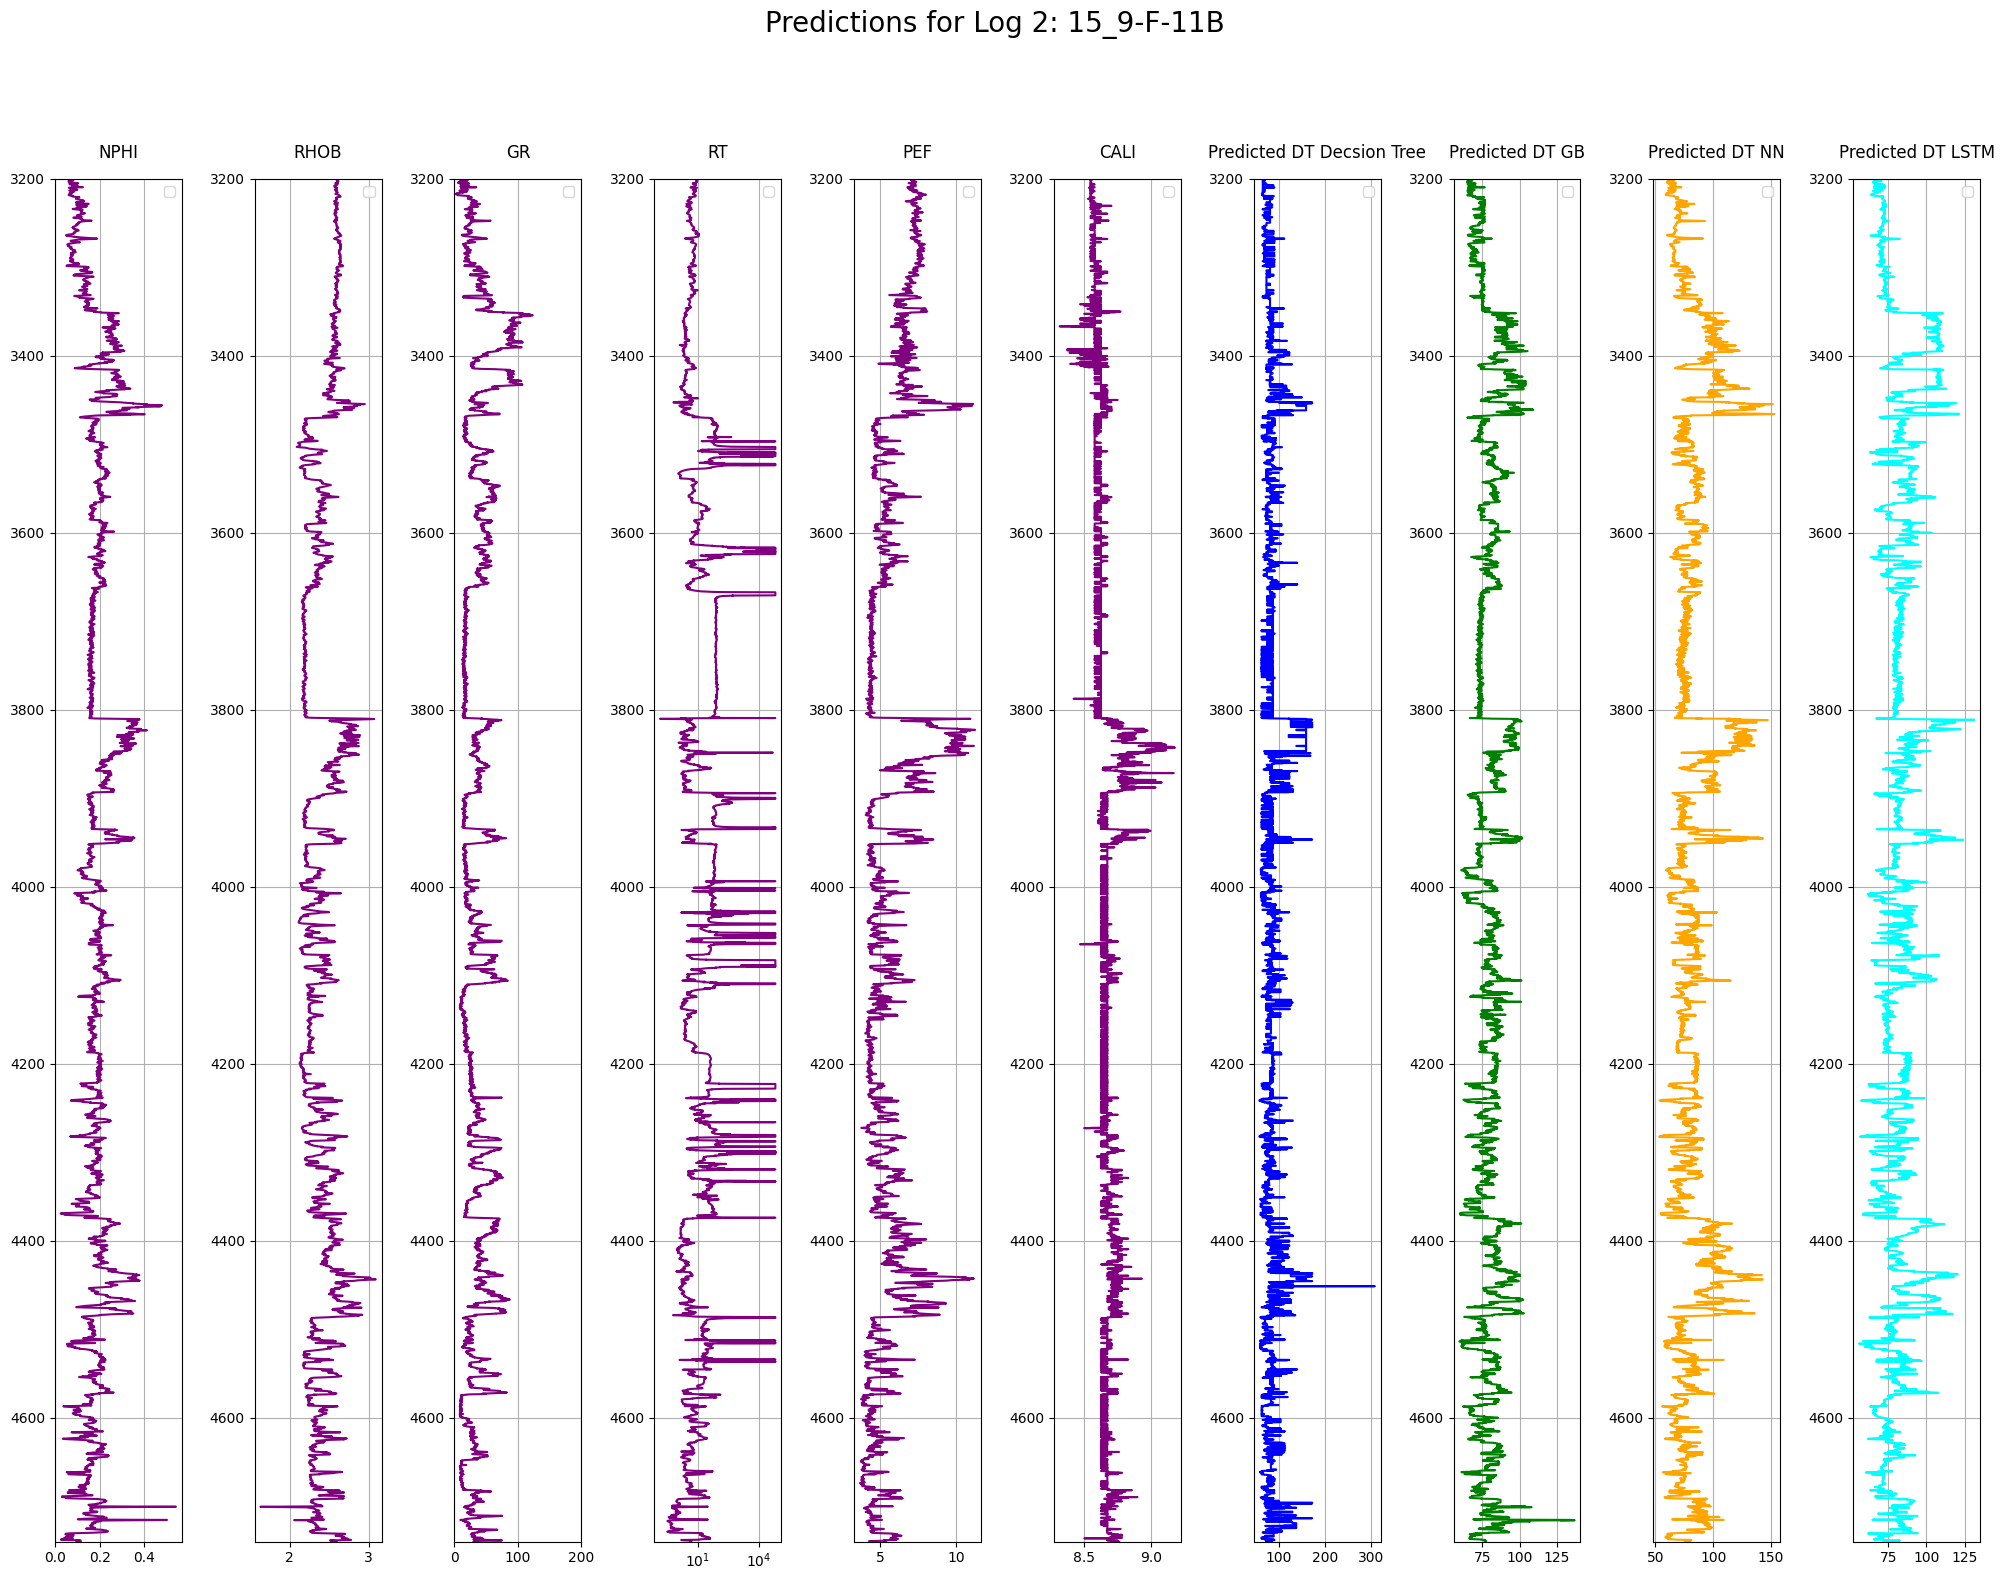

In [98]:
# Assuming `depth` is the depth information shared among all logs
makeplotpred(log2,
             ['purple', 'purple', 'purple', 'purple', 'purple', 'purple',  'blue', 'green',  'orange', 'cyan'],
             suptitle_str="Predictions for Log 2: 15_9-F-11B")

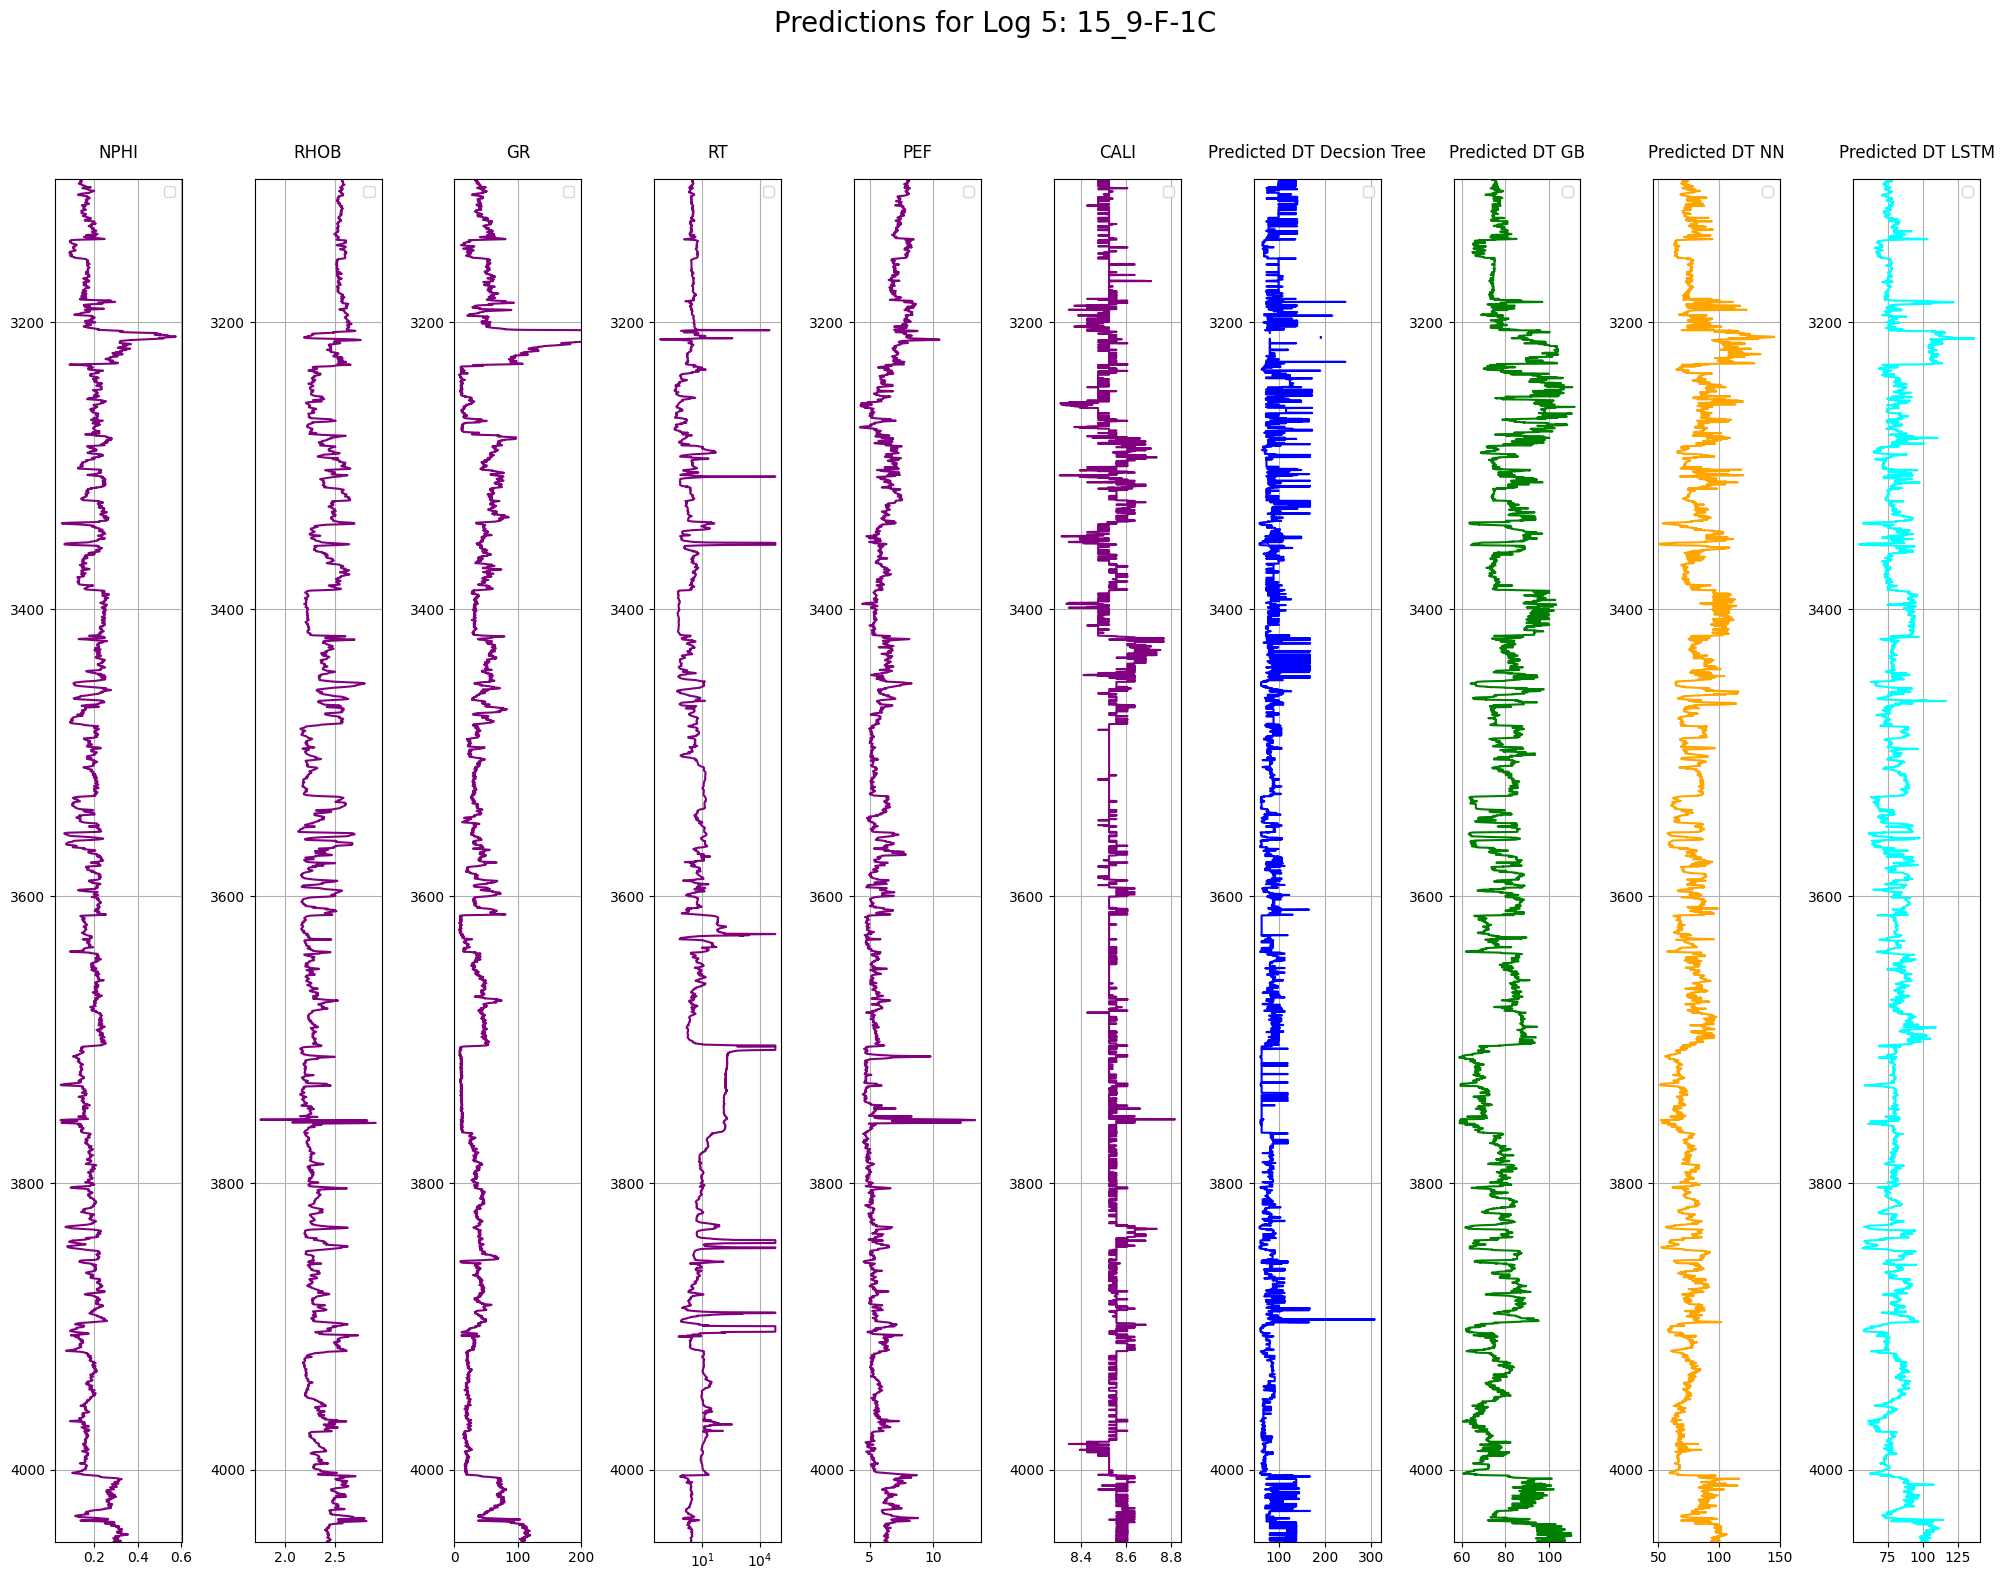

In [99]:
makeplotpred(log5,
             ['purple', 'purple', 'purple', 'purple', 'purple', 'purple',  'blue',  'green', 'orange', 'cyan'],
             suptitle_str="Predictions for Log 5: 15_9-F-1C")